In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm

2025-07-20 17:32:09.326696: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 17:32:09.332568: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 17:32:09.345684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753050729.368388  483816 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753050729.375572  483816 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-20 17:32:09.402138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Training History

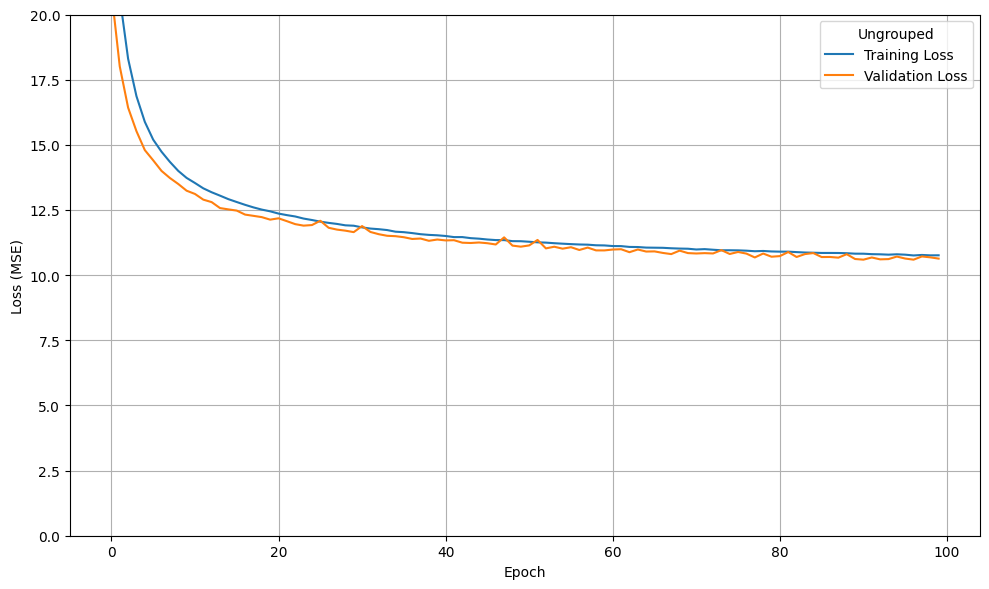

In [6]:
import pickle
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D

# Path to the history file
history_path = "/scratch/midway3/nkoebelin/mux_models_new/training_history/history_adj_10.pkl"

# Load the training history
with open(history_path, 'rb') as f:
    history = pickle.load(f)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')
#plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend(title="Ungrouped")
plt.grid(True)
plt.ylim(0,20)
plt.tight_layout()
#plt.show()
#plt.savefig("ungrouped_loss.png", dpi=300)

# Create and save Data

In [40]:
import numpy as np
import os
from tqdm import tqdm

# --- Configuration ---
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'

# --- Area test ranges (used as labels) ---
area_ranges = [
    (200, 2000, 'area_200_2000'),
    (10, 50, 'area_10_50'),
    #(10, 1e5, 'area_10_1e5'),
    (1e4, 1e5, 'area_1e4_1e5')
]

# --- Percentile function ---
def compute_percentiles(errors, percentiles=[68, 90, 95, 99]):
    return {f'{p}th_percentile': np.percentile(errors, p) for p in percentiles}

# --- Load mux pattern info ---
muxing_patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)

# --- Find all relevant files ---
all_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".npz") and "adj" in f])
if not all_files:
    raise FileNotFoundError("No files with 'adj' found in the specified directory.")

# --- Analyze each model file ---
for fname in all_files:
    model_id = os.path.splitext(fname)[0].replace("saved_data_", "")
    file_path = os.path.join(data_dir, fname)

    # Determine number of groups for this model
    if model_id in muxing_patterns:
        n_groups = muxing_patterns[model_id].shape[0]
    else:
        print(f"Warning: {model_id} not found in muxing_patterns.")
        n_groups = None

    with np.load(file_path) as data:
        area_test     = data['area_test']
        abs_errors    = data['abs_errors']
        radial_errors = data['radial_errors']
        pos_test      = data['pos_test']
        pos_pred      = data['pos_pred']

    # Process each area range
    for area_min, area_max, label in area_ranges:
        mask = (area_test >= area_min) & (area_test <= area_max)
        if not np.any(mask):
            print(f"No events in area range {area_min}-{area_max} for model {model_id}")
            continue

        filtered_errors = abs_errors[mask]
        filtered_radial = radial_errors[mask]
        filtered_area   = area_test[mask]
        filtered_pos_test = pos_test[mask]
        filtered_pos_pred = pos_pred[mask]

        percentiles = compute_percentiles(filtered_errors)
        result = {
            'mux_name': model_id,
            'n_groups': n_groups,
            'area_range': label,
            'mean_error': filtered_errors.mean(),
            'median_error': np.median(filtered_errors),
            'std_error': filtered_errors.std(),
            **percentiles,
            'abs_errors': filtered_errors,
            'radial_errors': filtered_radial,
            'area_test': filtered_area,
            'pos_test': filtered_pos_test,
            'pos_pred': filtered_pos_pred
        }

        # --- Print results ---
        print(f"\n--- Results for {model_id} | Area range: {label} ---")
        for k, v in result.items():
            if isinstance(v, np.ndarray):
                print(f"{k}: array shape {v.shape}")
            elif isinstance(v, float):
                print(f"{k}: {v:.3f}")
            else:
                print(f"{k}: {v}")



--- Results for adj_10 | Area range: area_200_2000 ---
mux_name: adj_10
n_groups: 33
area_range: area_200_2000
mean_error: 2.1096107959747314
median_error: 1.7642483711242676
std_error: 1.4609984159469604
68th_percentile: 2.415992259979248
90th_percentile: 4.056220054626465
95th_percentile: 5.003693580627441
99th_percentile: 6.977009296417236
abs_errors: array shape (100012,)
radial_errors: array shape (100012,)
area_test: array shape (100012,)
pos_test: array shape (100012, 2)
pos_pred: array shape (100012, 2)

--- Results for adj_10 | Area range: area_10_50 ---
mux_name: adj_10
n_groups: 33
area_range: area_10_50
mean_error: 6.930646896362305
median_error: 5.9120588302612305
std_error: 4.921053409576416
68th_percentile: 7.9400858879089355
90th_percentile: 12.639420509338379
95th_percentile: 15.37032413482666
99th_percentile: 23.186744689941406
abs_errors: array shape (48669,)
radial_errors: array shape (48669,)
area_test: array shape (48669,)
pos_test: array shape (48669, 2)
pos_pre

In [35]:
import numpy as np
import os
import pickle
from tqdm import tqdm
import re

# --- Configuration ---
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'
output_path = os.path.join(data_dir, 'adjacent_model_results.pkl')

# --- Area test ranges ---
area_ranges = [
    (200, 2000, 'area_200_2000'),
    (10, 50, 'area_10_50'),
    (1e4, 1e5, 'area_1e4_1e5'),
    (10, 1e5, 'area_10_1e5')
]

def extract_group_id(model_id):
    """Extracts group ID like 'adj_2' from 'adj_2', 'adj_2_rose', etc."""
    match = re.match(r"(adj_\d+)", model_id)
    return match.group(1) if match else model_id


# --- Percentile function ---
def compute_percentiles(errors, percentiles=[68, 90, 95, 99]):
    return {f'{p}th_percentile': np.percentile(errors, p) for p in percentiles}

# --- Load mux pattern info ---
muxing_patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)

# --- Find all adjacent model files ---
all_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".npz") and "adj" in f])
if not all_files:
    raise FileNotFoundError("No files with 'adj' found in the specified directory.")

# --- Collect all results ---
combined_results = {}

for fname in all_files:
    #model_id = os.path.splitext(fname)[0].replace("saved_data_", "")
    raw_id = os.path.splitext(fname)[0].replace("saved_data_", "")
    match = re.match(r"(adj_\d+)", raw_id)
    model_id = match.group(1) if match else raw_id  # fall back to raw if no match

    file_path = os.path.join(data_dir, fname)

    if model_id in muxing_patterns:
        n_groups = muxing_patterns[model_id].shape[0]
    else:
        print(f"Warning: {model_id} not found in muxing_patterns.")
        n_groups = None

    with np.load(file_path) as data:
        area_test     = data['area_test']
        abs_errors    = data['abs_errors']
        radial_errors = data['radial_errors']
        pos_test      = data['pos_test']
        pos_pred      = data['pos_pred']

    model_results = {}
    for area_min, area_max, label in area_ranges:
        mask = (area_test >= area_min) & (area_test <= area_max)
        if not np.any(mask):
            print(f"No events in area range {area_min}-{area_max} for model {model_id}")
            continue

        filtered_errors = abs_errors[mask]
        filtered_radial = radial_errors[mask]
        filtered_area   = area_test[mask]
        filtered_pos_test = pos_test[mask]
        filtered_pos_pred = pos_pred[mask]

        percentiles = compute_percentiles(filtered_errors)
        result = {
            'mux_name': model_id,
            'n_groups': n_groups,
            'area_range': label,
            'mean_error': filtered_errors.mean(),
            'median_error': np.median(filtered_errors),
            'std_error': filtered_errors.std(),
            **percentiles,
            'abs_errors': filtered_errors,
            'radial_errors': filtered_radial,
            'area_test': filtered_area,
            'pos_test': filtered_pos_test,
            'pos_pred': filtered_pos_pred
        }

        model_results[label] = result

    combined_results[model_id] = model_results

# --- Save results to file ---
with open(output_path, 'wb') as f:
    pickle.dump(combined_results, f)

print(f"\n✅ All adjacent model results saved to: {output_path}")



✅ All adjacent model results saved to: /scratch/midway3/nkoebelin/mux_data_new/adjacent_model_results.pkl


In [5]:
# All ungrouped

import numpy as np
import os
from tqdm import tqdm

# --- Configuration ---
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'
model_names = [f'ungrouped_{i}' for i in range(1, 11)]

# Area test ranges (name used only as a label, no saving)
area_ranges = [
    (200, 2000, 'area_200_2000'),
    (10, 50, 'area_10_50'),
    (10, 1e5, 'area_10_1e5'),
    (1e4, 1e5, 'area_1e4_1e5')
]

# Function to compute percentiles
def compute_percentiles(errors, percentiles=[68, 90, 95, 99]):
    return {f'{p}th_percentile': np.percentile(errors, p) for p in percentiles}

# Load muxing pattern info (for n_groups)
muxing_patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)

# --- Main storage ---
combined_results = {}

# --- Loop over all ungrouped model variants ---
for mux_name in model_names:
    print(f"\nProcessing model: {mux_name}")
    file_path = os.path.join(data_dir, f"saved_data_{mux_name}.npz")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    with np.load(file_path) as data:
        area_test     = data['area_test']
        abs_errors    = data['abs_errors']
        radial_errors = data['radial_errors']
        pos_test      = data['pos_test']
        pos_pred      = data['pos_pred']

    # Get number of groups
    base_name = mux_name.split("_")[0]
    if base_name in muxing_patterns:
        n_groups = muxing_patterns[base_name].shape[0]
    else:
        n_groups = "unknown"

    all_results = {}
    for area_min, area_max, label in area_ranges:
        mask = (area_test >= area_min) & (area_test <= area_max)
        if not np.any(mask):
            print(f"No events in area range {area_min}-{area_max}")
            continue

        filtered_errors = abs_errors[mask]
        filtered_radial = radial_errors[mask]
        filtered_area   = area_test[mask]
        filtered_pos_test = pos_test[mask]
        filtered_pos_pred = pos_pred[mask]

        percentiles = compute_percentiles(filtered_errors)

        result = {
            'mux_name': mux_name,
            'n_groups': n_groups,
            'mean_error': filtered_errors.mean(),
            'median_error': np.median(filtered_errors),
            'std_error': filtered_errors.std(),
            **percentiles,
            'abs_errors': filtered_errors,
            'radial_errors': filtered_radial,
            'area_test': filtered_area,
            'pos_test': filtered_pos_test,
            'pos_pred': filtered_pos_pred
        }

        all_results[label] = result

    # Store in main dictionary
    combined_results[mux_name] = all_results

    # Optional: print summary
    for label, stats in all_results.items():
        print(f"\n--- Results for {mux_name} - {label} ---")
        for k, v in stats.items():
            if isinstance(v, np.ndarray):
                print(f"{k}: array shape {v.shape}")
            elif isinstance(v, float):
                print(f"{k}: {v:.3f}")
            else:
                print(f"{k}: {v}")

import pickle

# Save the combined results dictionary
with open(os.path.join(data_dir, "combined_results_ungrouped.pkl"), "wb") as f:
    pickle.dump(combined_results, f)

# Optionally also save the percentile stats if you want to reuse them directly
with open(os.path.join(data_dir, "percentile_stats_ungrouped.pkl"), "wb") as f:
    pickle.dump(percentile_stats, f)


# Example access:
# combined_results["ungrouped_3"]["area_10_50"]["mean_error"]

# --- Configuration ---
area_key = 'area_10_1e5'
model_names = [f'ungrouped_{i}' for i in range(1, 11)]
bins = np.linspace(0, 7.5, 1000)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
all_histograms = []
all_percentiles = {
    'Median': [],
    '68th': [],
    '95th': [],
    '99th': []
}

# --- Collect histograms and metrics from all runs ---
for name in model_names:
    abs_errors = combined_results[name][area_key]['abs_errors']
    
    # Histogram
    hist, _ = np.histogram(abs_errors, bins=bins)
    all_histograms.append(hist)

    # Percentiles
    all_percentiles['Median'].append(np.median(abs_errors))
    all_percentiles['68th'].append(np.percentile(abs_errors, 68))
    all_percentiles['95th'].append(np.percentile(abs_errors, 95))
    all_percentiles['99th'].append(np.percentile(abs_errors, 99))

# --- Compute average histogram ---
hist_sum = np.sum(all_histograms, axis=0)
hist_avg = hist_sum / len(all_histograms)

# --- Compute average + max deviation for percentiles ---
percentile_stats = {}
for key, values in all_percentiles.items():
    values = np.array(values)
    mean = np.mean(values)
    max_dev = np.max(np.abs(values - mean))
    percentile_stats[key] = (mean, max_dev)


Processing model: ungrouped_1

--- Results for ungrouped_1 - area_200_2000 ---
mux_name: ungrouped_1
n_groups: 253
mean_error: 1.257529854774475
median_error: 1.099039077758789
std_error: 0.8063580393791199
68th_percentile: 1.4665344953536987
90th_percentile: 2.3036179542541504
95th_percentile: 2.768563747406006
99th_percentile: 3.7639732360839844
abs_errors: array shape (100012,)
radial_errors: array shape (100012,)
area_test: array shape (100012,)
pos_test: array shape (100012, 2)
pos_pred: array shape (100012, 2)

--- Results for ungrouped_1 - area_10_50 ---
mux_name: ungrouped_1
n_groups: 253
mean_error: 5.664931297302246
median_error: 4.675757884979248
std_error: 4.474218845367432
68th_percentile: 6.272992134094238
90th_percentile: 10.427009582519531
95th_percentile: 13.244471549987793
99th_percentile: 21.998546600341797
abs_errors: array shape (48669,)
radial_errors: array shape (48669,)
area_test: array shape (48669,)
pos_test: array shape (48669, 2)
pos_pred: array shape (4866

NameError: name 'percentile_stats' is not defined

In [30]:
import os
import h5py
import numpy as np
from sklearn.model_selection import train_test_split

def get_global_test_indices(raw_data_path, seed=42):
    file_names = sorted([f for f in os.listdir(raw_data_path) if f.endswith(".hdf5")])
    event_counts = []
    for fname in file_names[:100]:
        with h5py.File(os.path.join(raw_data_path, fname), "r") as f:
            event_counts.append(len(f["interface_x"]))
    total_events = sum(event_counts)

    # Recreate split
    all_indices = np.arange(total_events)
    _, temp_indices = train_test_split(all_indices, test_size=0.5, random_state=seed)
    _, test_indices = train_test_split(temp_indices, test_size=0.8, random_state=seed)

    return test_indices, file_names, event_counts

if __name__ == "__main__":
    raw_data_path = "/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/"
    idx_test, filenames, counts = get_global_test_indices(raw_data_path)
    np.save("idx_test_global.npy", idx_test)
    print(f"Saved test indices: {len(idx_test)} entries")

Saved test indices: 381963 entries


In [36]:
import os
import h5py
import numpy as np
from sklearn.model_selection import train_test_split

# Set path
raw_data_path = "/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/"

# Load and concatenate area values
file_names = sorted([f for f in os.listdir(raw_data_path) if f.endswith(".hdf5")])
file_names = file_names[:100]

s2_areas = []

for fname in file_names:
    with h5py.File(os.path.join(raw_data_path, fname), "r") as f:
        hits = np.array(f["hitpatterns"])
        s2_area = np.sum(hits, axis=1)
        s2_areas.append(s2_area)

s2_areas = np.concatenate(s2_areas)
print(f"Total events: {len(s2_areas)}")

# Apply same area cut as during training
valid_mask = (s2_areas >= 10) & (s2_areas < 1e5)
valid_indices = np.where(valid_mask)[0]

# Reproduce test split from valid events
_, temp_indices = train_test_split(valid_indices, test_size=0.5, random_state=42)
_, test_indices = train_test_split(temp_indices, test_size=0.8, random_state=42)

# Save for later
np.save("idx_test_global_area_cut.npy", test_indices)
print(f"Saved {len(test_indices)} area-cut test indices.")


Total events: 954906
Saved 377340 area-cut test indices.


In [31]:
def build_index_lookup(raw_data_path, output_file="global_index_lookup.npy"):
    import os, h5py, numpy as np

    file_names = sorted([f for f in os.listdir(raw_data_path) if f.endswith(".hdf5")])
    lookup = {}

    global_idx = 0
    for fname in file_names[:100]:
        with h5py.File(os.path.join(raw_data_path, fname), "r") as f:
            n_events = len(f["interface_x"])
        for local_idx in range(n_events):
            lookup[global_idx] = (fname, local_idx)
            global_idx += 1

    np.save(output_file, lookup)
    print(f"Saved lookup with {len(lookup)} entries to {output_file}")

# Example usage
raw_data_path = "/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/"
build_index_lookup(raw_data_path)

Saved lookup with 954906 entries to global_index_lookup.npy


# Load Data

In [2]:
import pickle

with open("/scratch/midway3/nkoebelin/mux_data_new/combined_results_ungrouped.pkl", "rb") as f:
    combined_results_ungrouped = pickle.load(f)

with open("/scratch/midway3/nkoebelin/mux_data_new/adjacent_model_results.pkl", "rb") as f:
    combined_results_adj = pickle.load(f)


In [3]:
# Load supporting files
idx_test_array = np.load("idx_test_global.npy")
lookup_dict = np.load("global_index_lookup.npy", allow_pickle=True).item()
pmt_xy_top = np.load("hex_pattern_data.npz", allow_pickle=True)["pmt_xy_top"]
mux_patterns = np.load("mux_patterns_all_new.npz", allow_pickle=True)
raw_data_path = "/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/"
rns = np.load("mux_patterns_all_new.npz", allow_pickle=True)


# General Pattern Properties

In [9]:
import numpy as np
from scipy.stats import entropy

# Load patterns
patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)

print("🔍 Unique group size counts for patterns starting with 'adj_':\n")

for name in patterns.files:
    if name.startswith("adj_") and name not in ["adj_mosaik", "adj_football_small", "adj_football_large"]:
        pattern = patterns[name]
        group_sizes = np.sum(pattern != -1, axis=1)
        unique_sizes, counts = np.unique(group_sizes, return_counts=True)

        print(f"{name:20s} → unique_sizes: {len(unique_sizes)}  (sizes: {unique_sizes.tolist()})")


🔍 Unique group size counts for patterns starting with 'adj_':

adj_4                → unique_sizes: 4  (sizes: [1, 2, 3, 4])
adj_8                → unique_sizes: 8  (sizes: [1, 2, 3, 4, 5, 6, 7, 8])
adj_9                → unique_sizes: 4  (sizes: [1, 2, 6, 9])
adj_10               → unique_sizes: 8  (sizes: [1, 2, 3, 5, 6, 8, 9, 10])
adj_7                → unique_sizes: 3  (sizes: [1, 5, 7])
adj_3                → unique_sizes: 2  (sizes: [1, 3])
adj_2                → unique_sizes: 2  (sizes: [1, 2])
adj_5                → unique_sizes: 4  (sizes: [1, 3, 4, 5])
adj_6                → unique_sizes: 4  (sizes: [1, 3, 5, 6])


# Visuals

/scratch/local/jobs/33259960/ipykernel_190707/534860500.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Adjacent 2", loc="upper left", fontsize=18, frameon=True, fancybox=True)


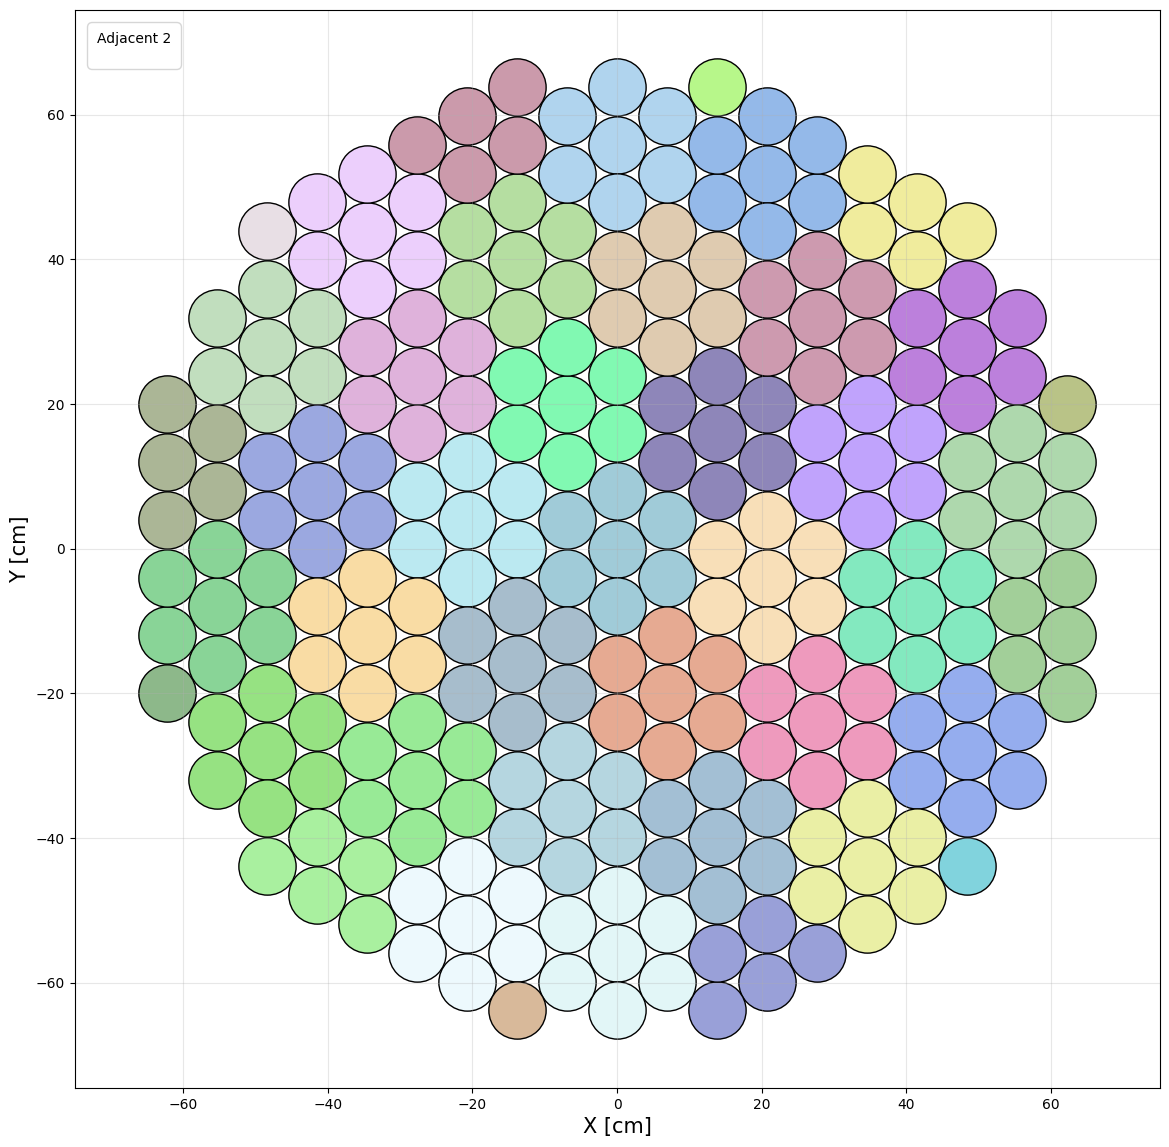

In [12]:
# Load hex data
hex_data = np.load("hex_pattern_data.npz", allow_pickle=True)
pmt_xy_top = hex_data["pmt_xy_top"]

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

# Function to generate pastel colors
def generate_pastel_colors(num_colors):
    pastel_colors = []
    for _ in range(num_colors):
        base_color = [random.random() for _ in range(3)]
        pastel_color = [(1 + c) / 2 for c in base_color]
        pastel_colors.append(mcolors.to_hex(pastel_color))
    return pastel_colors

# Single plot function with optional saving
def plot_pmt_groups_single(pmt_positions, groups, title="PMT Group Plot", save_path=None):
    plt.figure(figsize=(14, 14))
    
    num_groups = len(groups)
    pastel_colors = generate_pastel_colors(num_groups)
    import seaborn as sns
    #pastel_colors = sns.color_palette("Paired", n_colors=num_groups)
    #pastel_colors = plt.get_cmap("tab20").colors  # 20 well-separated colors

    plt.grid(alpha=0.3)


    # Map PMTs to group number
    pmt_to_group = {}
    for group_number, group in enumerate(groups):
        for pmt in group:
            if 0 <= pmt < len(pmt_positions):
                pmt_to_group[pmt] = group_number + 1

    # Plot PMTs
    for i, group in enumerate(groups):
        pmt_x = [pmt_positions[pmt][0] for pmt in group if 0 <= pmt < len(pmt_positions)]
        pmt_y = [pmt_positions[pmt][1] for pmt in group if 0 <= pmt < len(pmt_positions)]
        plt.scatter(pmt_x, pmt_y, c=[pastel_colors[i]], edgecolor='black', marker='o', s=1700)
        
        for pmt in group:
            if 0 <= pmt < len(pmt_positions):
                group_number = pmt_to_group.get(pmt, '?')
                #plt.text(pmt_positions[pmt][0], pmt_positions[pmt][1], str(group_number),
                         #fontsize=18, ha='center', va='center', color='black')

    #plt.title(title, fontsize=25)
    plt.xlabel('X [cm]', fontsize=15)
    plt.ylabel('Y [cm]', fontsize=15)
    plt.legend(title="Adjacent 2", loc="upper left", fontsize=18, frameon=True, fancybox=True)
    #plt.grid(alpha=0.3)
    plt.axis('equal')
    plt.xlim(-75,75)
    plt.ylim(-75,75)


    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")

    plt.show()

mux_patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)
groups = mux_patterns['adj_7'].tolist()
pmt_positions = pmt_xy_top

# To save as PNG
plot_pmt_groups_single(pmt_positions, groups, title=f'Adjacent "Football Large", {len(mux_patterns["adj_football_large"])} Groups')#, save_path="20250519_grouping_football_large_adjacent.png")


In [33]:
def plot_hitpattern_event(
    mux_name,
    test_idx,
    raw_data_path,
    npz_data_path,
    mux_pattern_file,
    hex_geometry_file,
    idx_test_array,
    lookup_dict,
    save_image=False,
    image_dir="/home/nkoebelin/Images",
    #filename=None,
):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    from matplotlib.patches import Circle
    import numpy as np
    import h5py, os

    os.makedirs(image_dir, exist_ok=True)

    global_idx = idx_test_array[test_idx]
    filename, local_idx = lookup_dict[global_idx]
    h5_path = os.path.join(raw_data_path, filename)

    # --- same as before ---
    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]
    PMTs_top = len(pmt_x_top)

    mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
    groups = [np.array(g) for g in mux]

    with h5py.File(h5_path, "r") as f:
        hitpattern = f["hitpatterns"][local_idx]
        interface_x = f["interface_x"][local_idx]
        interface_y = f["interface_y"][local_idx]
        s2_area = np.sum(hitpattern)

    npz = np.load(npz_data_path)
    pred = npz["pos_pred"][test_idx]
    true = npz["pos_test"][test_idx]
    abs_err = npz["abs_errors"][test_idx]

    group_values = np.zeros(len(groups))
    for i, group in enumerate(groups):
        if len(group) > 0:
            group_values[i] = np.sum(hitpattern[group])

    pmt_intensity = np.zeros(PMTs_top)
    for i, group in enumerate(groups):
        if len(group) > 0:
            pmt_intensity[group] = group_values[i] / len(group)

    # Plot
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(pmt_x_top, pmt_y_top, c=pmt_intensity, cmap='viridis', marker='o', s=700, norm=LogNorm())
    plt.colorbar(sc, label='Normalized Area [PE]')
    plt.scatter(interface_x, interface_y, c='red', marker='o', s=100, label='MC Position')
    plt.scatter(pred[0], pred[1], c='k', marker='+', s=200, label=f'Reconstruction\nError={abs_err:.2f} cm')

    circle = Circle((0, 0), 67, color='k', fill=False, linewidth=1)
    plt.gca().add_patch(circle)

    plt.title(f"{mux_name} | TestIdx={test_idx}, S2 Area={s2_area:.1f}, Error={abs_err:.2f} cm")
    plt.xlabel("X [cm]")
    plt.ylabel("Y [cm]")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if save_image:
        default_name = f"{mux_name}_event{test_idx}.png"
        plt.savefig(os.path.join(image_dir, default_name), dpi=300)
        print(f"Saved: {os.path.join(image_dir, default_name)}")

    plt.show()


def compare_patterns_side_by_side(
    mux1, mux2,
    test_idx,
    idx_test_array,
    lookup_dict,
    raw_data_path,
    npz_base_path,
    mux_pattern_file,
    hex_geometry_file,
    save_image=False,
    image_dir="/home/nkoebelin/Images",
    filename=None
):
    import os
    import numpy as np
    import h5py
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    from matplotlib.patches import Circle
    import matplotlib.gridspec as gridspec

    os.makedirs(image_dir, exist_ok=True)

    # Geometry
    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]
    PMTs_top = len(pmt_x_top)

    # Mux patterns
    patterns = np.load(mux_pattern_file, allow_pickle=True)
    groups1 = [np.array(g) for g in patterns[mux1]]
    groups2 = [np.array(g) for g in patterns[mux2]]

    # Load raw event
    global_idx = idx_test_array[test_idx]
    fname, local_idx = lookup_dict[global_idx]
    h5_path = os.path.join(raw_data_path, fname)
    with h5py.File(h5_path, "r") as f:
        hitpattern = f["hitpatterns"][local_idx]
        interface_x = f["interface_x"][local_idx]
        interface_y = f["interface_y"][local_idx]
        s2_area = np.sum(hitpattern)
    true_pos = (interface_x, interface_y)

    # Apply muxing
    def apply_mux(groups):
        group_vals = np.array([np.sum(hitpattern[g]) if len(g) > 0 else 0 for g in groups])
        pmt_vals = np.zeros(PMTs_top)
        for i, g in enumerate(groups):
            if len(g) > 0:
                pmt_vals[g] = group_vals[i] / len(g)
        return pmt_vals

    pmt1 = apply_mux(groups1)
    pmt2 = apply_mux(groups2)

    # Load predictions
    def load_prediction(mux_name):
        d = np.load(os.path.join(npz_base_path, f"saved_data_{mux_name}.npz"))
        return d["pos_pred"][test_idx], d["abs_errors"][test_idx]

    pred1, err1 = load_prediction(mux1)
    pred2, err2 = load_prediction(mux2)

    # --- Plot ---
    fig = plt.figure(figsize=(14, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.25)

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    cax = fig.add_subplot(gs[2])

    vmax = max(pmt1.max(), pmt2.max())

    for ax, mux, pmt_vals, pred, err in zip(
        [ax1, ax2],
        [mux1, mux2],
        [pmt1, pmt2],
        [pred1, pred2],
        [err1, err2]
    ):
        sc = ax.scatter(pmt_x_top, pmt_y_top, c=pmt_vals, cmap='viridis', norm=LogNorm(vmax=vmax), s=200)
        ax.scatter(*true_pos, c='red', marker='o', s=50, label='MC Position')
        ax.scatter(*pred, c='k', marker='+', s=100, label=f'Reconstruction\nError={err:.2f} cm')
        ax.add_patch(Circle((0, 0), 67, color='k', fill=False, linewidth=1))
        ax.set_title(f"{mux}\nError = {err:.2f} cm")
        ax.set_xlabel("X [cm]")
        ax.set_ylabel("Y [cm]")
        #ax.legend()
        ax.set_aspect('equal')
        ax.grid(True)

    # Shared colorbar
    cbar = fig.colorbar(sc, cax=cax)
    cbar.set_label("Normalized Area [PE]")

    fig.suptitle(f"Event {test_idx} | S2 Area = {s2_area:.1f}", fontsize=14)
    plt.subplots_adjust(top=0.85)
    #plt.tight_layout(rect=[0, 0.03, 1, 0.93])

    if save_image:
        default_name = f"{mux1}_vs_{mux2}_event{test_idx}.png"
        plt.savefig(os.path.join(image_dir, default_name), dpi=300)
        print(f"Saved: {os.path.join(image_dir, default_name)}")

    plt.show()


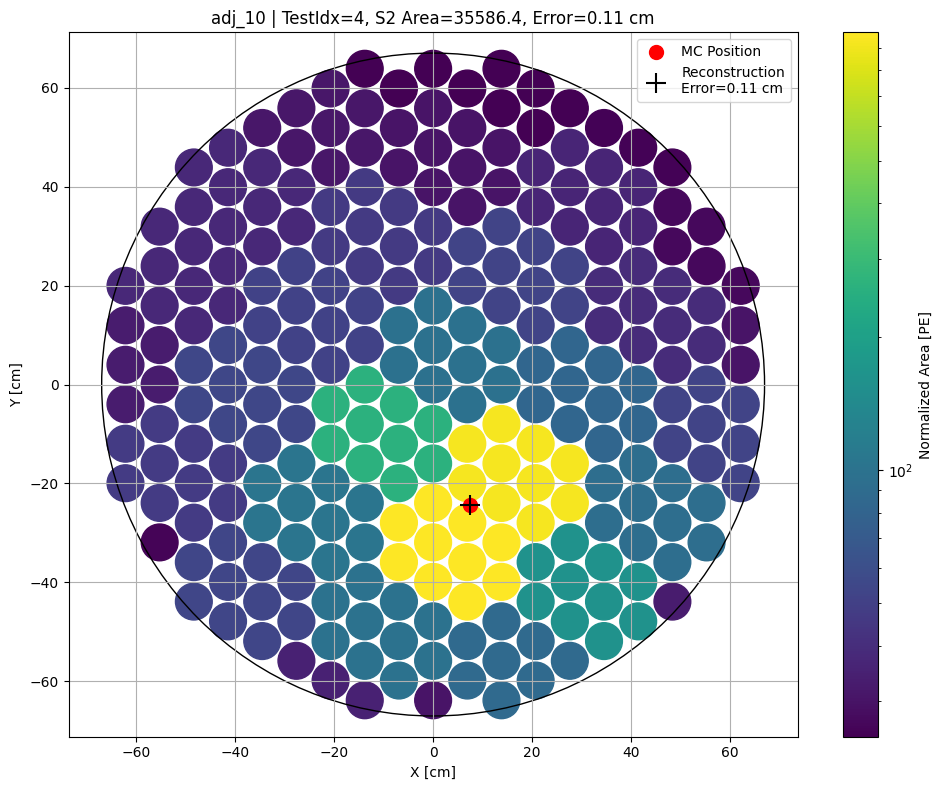

In [43]:
# Load required data
mux_name = "adj_10"
idx_test_array = np.load("idx_test_global_area_cut.npy")
lookup_dict = np.load("global_index_lookup.npy", allow_pickle=True).item()
test_idx = 4
global_idx = idx_test_array[test_idx]
filename, local_idx = lookup_dict[global_idx]

npz_path = f"/scratch/midway3/nkoebelin/mux_data_new/saved_data_{mux_name}.npz"
npz = np.load(npz_path)

# Call the plotting function using global_idx for prediction arrays
plot_hitpattern_event(
    mux_name=mux_name,
    test_idx=test_idx,
    raw_data_path="/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/",
    npz_data_path=npz_path,
    mux_pattern_file="mux_patterns_all_new.npz",
    hex_geometry_file="hex_pattern_data.npz",
    idx_test_array=idx_test_array,
    lookup_dict=lookup_dict,
    save_image=False
)


In [52]:
def plot_hitpattern_grid(
    test_idx,
    raw_data_path,
    base_npz_path,
    mux_pattern_file,
    hex_geometry_file,
    idx_test_array,
    lookup_dict,
    save_image=False,
    image_dir="/home/nkoebelin/Images"
):
    os.makedirs(image_dir, exist_ok=True)

    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]
    PMTs_top = len(pmt_x_top)

    global_idx = idx_test_array[test_idx]
    filename, local_idx = lookup_dict[global_idx]
    h5_path = os.path.join(raw_data_path, filename)

    with h5py.File(h5_path, "r") as f:
        hitpattern = f["hitpatterns"][local_idx]
        interface_x = f["interface_x"][local_idx]
        interface_y = f["interface_y"][local_idx]
        s2_area = np.sum(hitpattern)

    fig, axes = plt.subplots(3, 3, figsize=(18, 16))
    fig.suptitle(f"Hitpattern Comparison | TestIdx={test_idx}", fontsize=20)

    all_pmt_intensities = []  # for global color scaling

    # First pass to compute global vmin and vmax
    for i in range(9):
        group_num = i + 2
        mux_name = f"adj_{group_num}"
        mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
        groups = [np.array(g) for g in mux]

        group_values = np.zeros(len(groups))
        for j, group in enumerate(groups):
            if len(group) > 0:
                group_values[j] = np.sum(hitpattern[group])

        pmt_intensity = np.zeros(PMTs_top)
        for j, group in enumerate(groups):
            if len(group) > 0:
                pmt_intensity[group] = group_values[j] / len(group)

        all_pmt_intensities.append(pmt_intensity)

    # Compute global color scale bounds (ignoring zeros to avoid LogNorm errors)
    all_values = np.concatenate(all_pmt_intensities)
    vmin = np.min(all_values[all_values > 0])
    vmax = np.max(all_values)

    # Second pass to plot
    for i, ax in enumerate(axes.flatten()):
        group_num = i + 2
        mux_name = f"adj_{group_num}"
        npz_path = os.path.join(base_npz_path, f"saved_data_{mux_name}.npz")
        mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
        groups = [np.array(g) for g in mux]

        npz = np.load(npz_path)
        pred = npz["pos_pred"][test_idx]
        abs_err = npz["abs_errors"][test_idx]

        pmt_intensity = all_pmt_intensities[i]
        sc = ax.scatter(pmt_x_top, pmt_y_top, c=pmt_intensity, cmap='viridis', marker='o', s=200, norm=LogNorm(vmin=vmin, vmax=vmax))
        ax.scatter(interface_x, interface_y, c='red', marker='o', s=100, label='MC Position')
        ax.scatter(pred[0], pred[1], c='k', marker='+', s=200, label=f'Error={abs_err:.2f} cm')

        circle = Circle((0, 0), 67, color='k', fill=False, linewidth=1)
        ax.add_patch(circle)

        ax.set_title(f"{mux_name} | Error={abs_err:.2f} cm", fontsize=12)
        ax.set_xlabel("X [cm]")
        ax.set_ylabel("Y [cm]")
        ax.axis('equal')
        ax.grid(True)

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='Normalized Area [PE]')

    # Global legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.tight_layout(rect=[0, 0, 0.91, 0.95])

    if save_image:
        out_path = os.path.join(image_dir, f"hitpattern_grid_event{test_idx}.png")
        plt.savefig(out_path, dpi=300)
        print(f"Saved: {out_path}")

    plt.show()



In [20]:
def plot_hitpattern_grid(
    test_idx,
    raw_data_path,
    base_npz_path,
    mux_pattern_file,
    hex_geometry_file,
    idx_test_array,
    lookup_dict,
    save_image=False,
    image_dir="/home/nkoebelin/Images"
):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    from matplotlib.patches import Circle
    import numpy as np
    import h5py, os

    # --- Font size setup to match reference layout ---
    plt.rcParams.update({
        "font.size": 26,
        "axes.labelsize": 26,
        "axes.titlesize": 28,
        "xtick.labelsize": 23,
        "ytick.labelsize": 23,
        "legend.fontsize": 26
    })

    os.makedirs(image_dir, exist_ok=True)

    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]
    PMTs_top = len(pmt_x_top)

    global_idx = idx_test_array[test_idx]
    filename, local_idx = lookup_dict[global_idx]
    h5_path = os.path.join(raw_data_path, filename)

    with h5py.File(h5_path, "r") as f:
        hitpattern = f["hitpatterns"][local_idx]
        interface_x = f["interface_x"][local_idx]
        interface_y = f["interface_y"][local_idx]
        s2_area = np.sum(hitpattern)

    fig, axes = plt.subplots(3, 3, figsize=(18, 18))

    all_pmt_intensities = []  # for global color scaling

    # First pass to compute global vmin and vmax
    for i in range(9):
        group_num = i + 2
        mux_name = f"adj_{group_num}"
        mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
        groups = [np.array(g) for g in mux]

        group_values = np.zeros(len(groups))
        for j, group in enumerate(groups):
            if len(group) > 0:
                group_values[j] = np.sum(hitpattern[group])

        pmt_intensity = np.zeros(PMTs_top)
        for j, group in enumerate(groups):
            if len(group) > 0:
                pmt_intensity[group] = group_values[j] / len(group)

        all_pmt_intensities.append(pmt_intensity)

    # Compute global color scale bounds (ignoring zeros to avoid LogNorm errors)
    all_values = np.concatenate(all_pmt_intensities)
    vmin = np.min(all_values[all_values > 0])
    vmax = np.max(all_values)

    # Second pass to plot
    for i, ax in enumerate(axes.flatten()):
        group_num = i + 2
        mux_name = f"adj_{group_num}"
        npz_path = os.path.join(base_npz_path, f"saved_data_{mux_name}.npz")
        mux = np.load(mux_pattern_file, allow_pickle=True)[mux_name]
        groups = [np.array(g) for g in mux]

        npz = np.load(npz_path)
        pred = npz["pos_pred"][test_idx]
        abs_err = npz["abs_errors"][test_idx]

        pmt_intensity = all_pmt_intensities[i]
        sc = ax.scatter(pmt_x_top, pmt_y_top, c=pmt_intensity, cmap='viridis', marker='o', s=250, norm=LogNorm(vmin=vmin, vmax=vmax))
        ax.scatter(interface_x, interface_y, c='red', marker='o', s=180, label='MC Position')
        ax.scatter(pred[0], pred[1], c='k', marker='+', s=400, label=f'Error={abs_err:.2f} cm')

        circle = Circle((0, 0), 67, color='k', fill=False, linewidth=1)
        ax.add_patch(circle)

        # Set custom title
        ax.set_title(f"Adjacent {group_num}", fontsize=28)

        #ax.set_xlabel("X [cm]")
        #ax.set_ylabel("Y [cm]")
        ax.set_aspect('equal')
        ax.set_xlim(-70, 70)
        ax.set_ylim(-70, 70)
        ax.grid(alpha=0.3)

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='S2 Area [PE]')

    # Global legend
    #handles, labels = axes[0, 0].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper right')

    plt.tight_layout(rect=[0, 0, 0.91, 0.97])

    if save_image:
        out_path = os.path.join(image_dir, f"adjacent_hitpattern_grid_event{test_idx}.png")
        plt.savefig(out_path, dpi=300)
        print(f"Saved: {out_path}")

    plt.show()


/scratch/local/jobs/33259960/ipykernel_190707/1415739357.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.97])


Saved: /home/nkoebelin/Images/adjacent_hitpattern_grid_event4.png


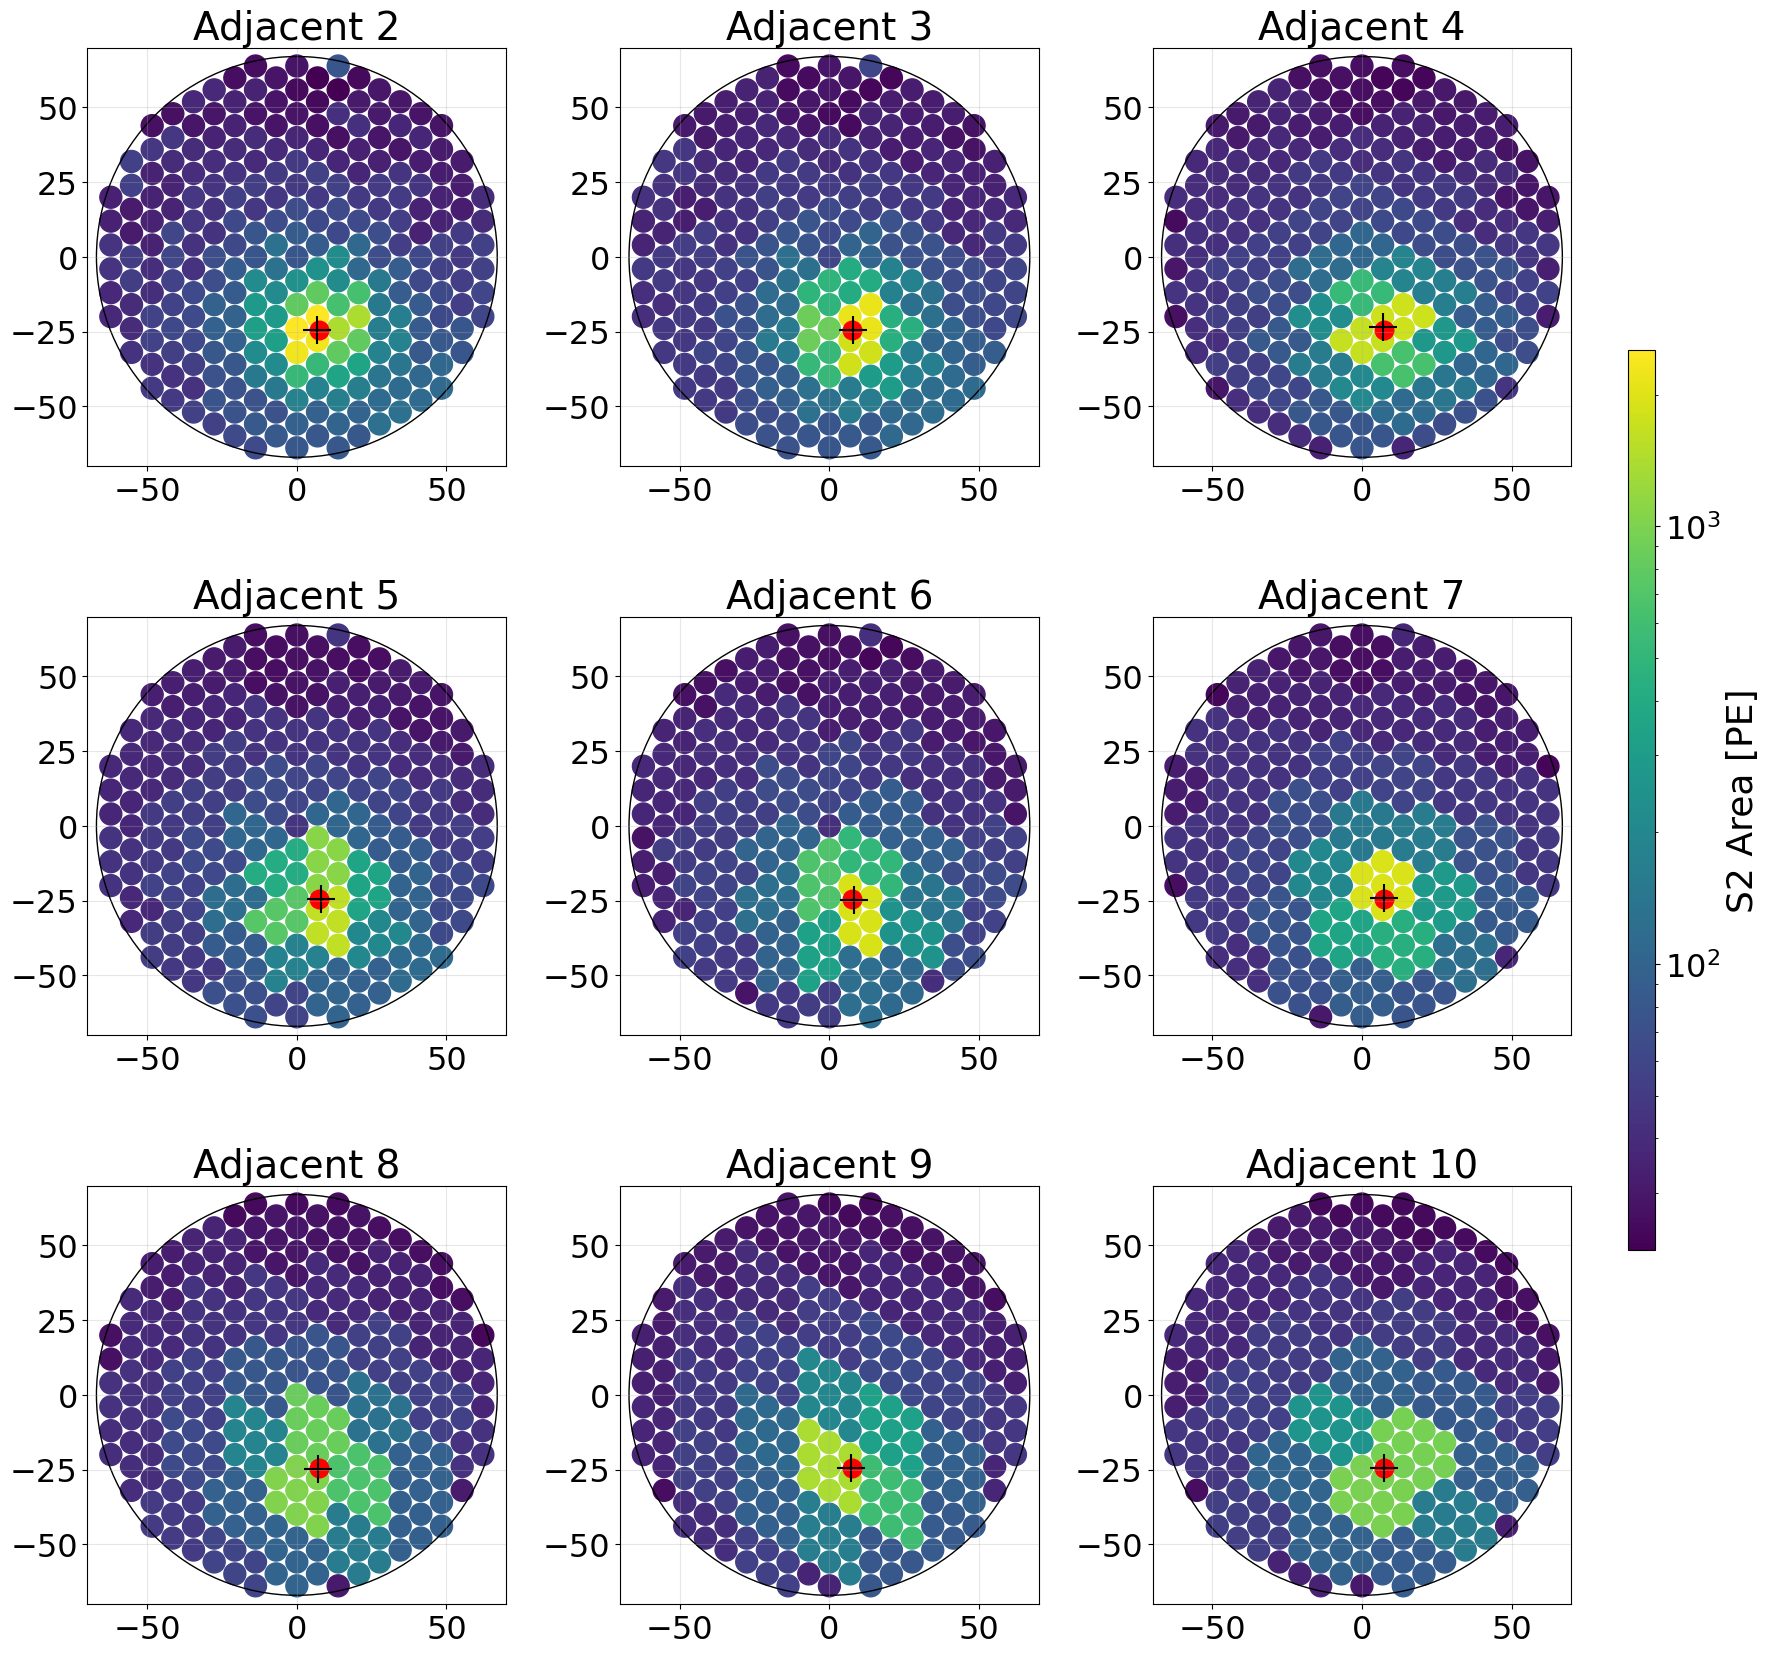

In [22]:
plot_hitpattern_grid(
    test_idx=4,
    raw_data_path="/project2/lgrandi/svetter/simulations_for_posrec/s2_hitpattern_sims_for_posrec/",
    base_npz_path="/scratch/midway3/nkoebelin/mux_data_new",
    mux_pattern_file="mux_patterns_all_new.npz",
    hex_geometry_file="hex_pattern_data.npz",
    idx_test_array=np.load("idx_test_global_area_cut.npy"),
    lookup_dict=np.load("global_index_lookup.npy", allow_pickle=True).item(),
    save_image=False
)


Saved: /home/nkoebelin/Images/adjacent_grouping_layouts_custom_highlight.png


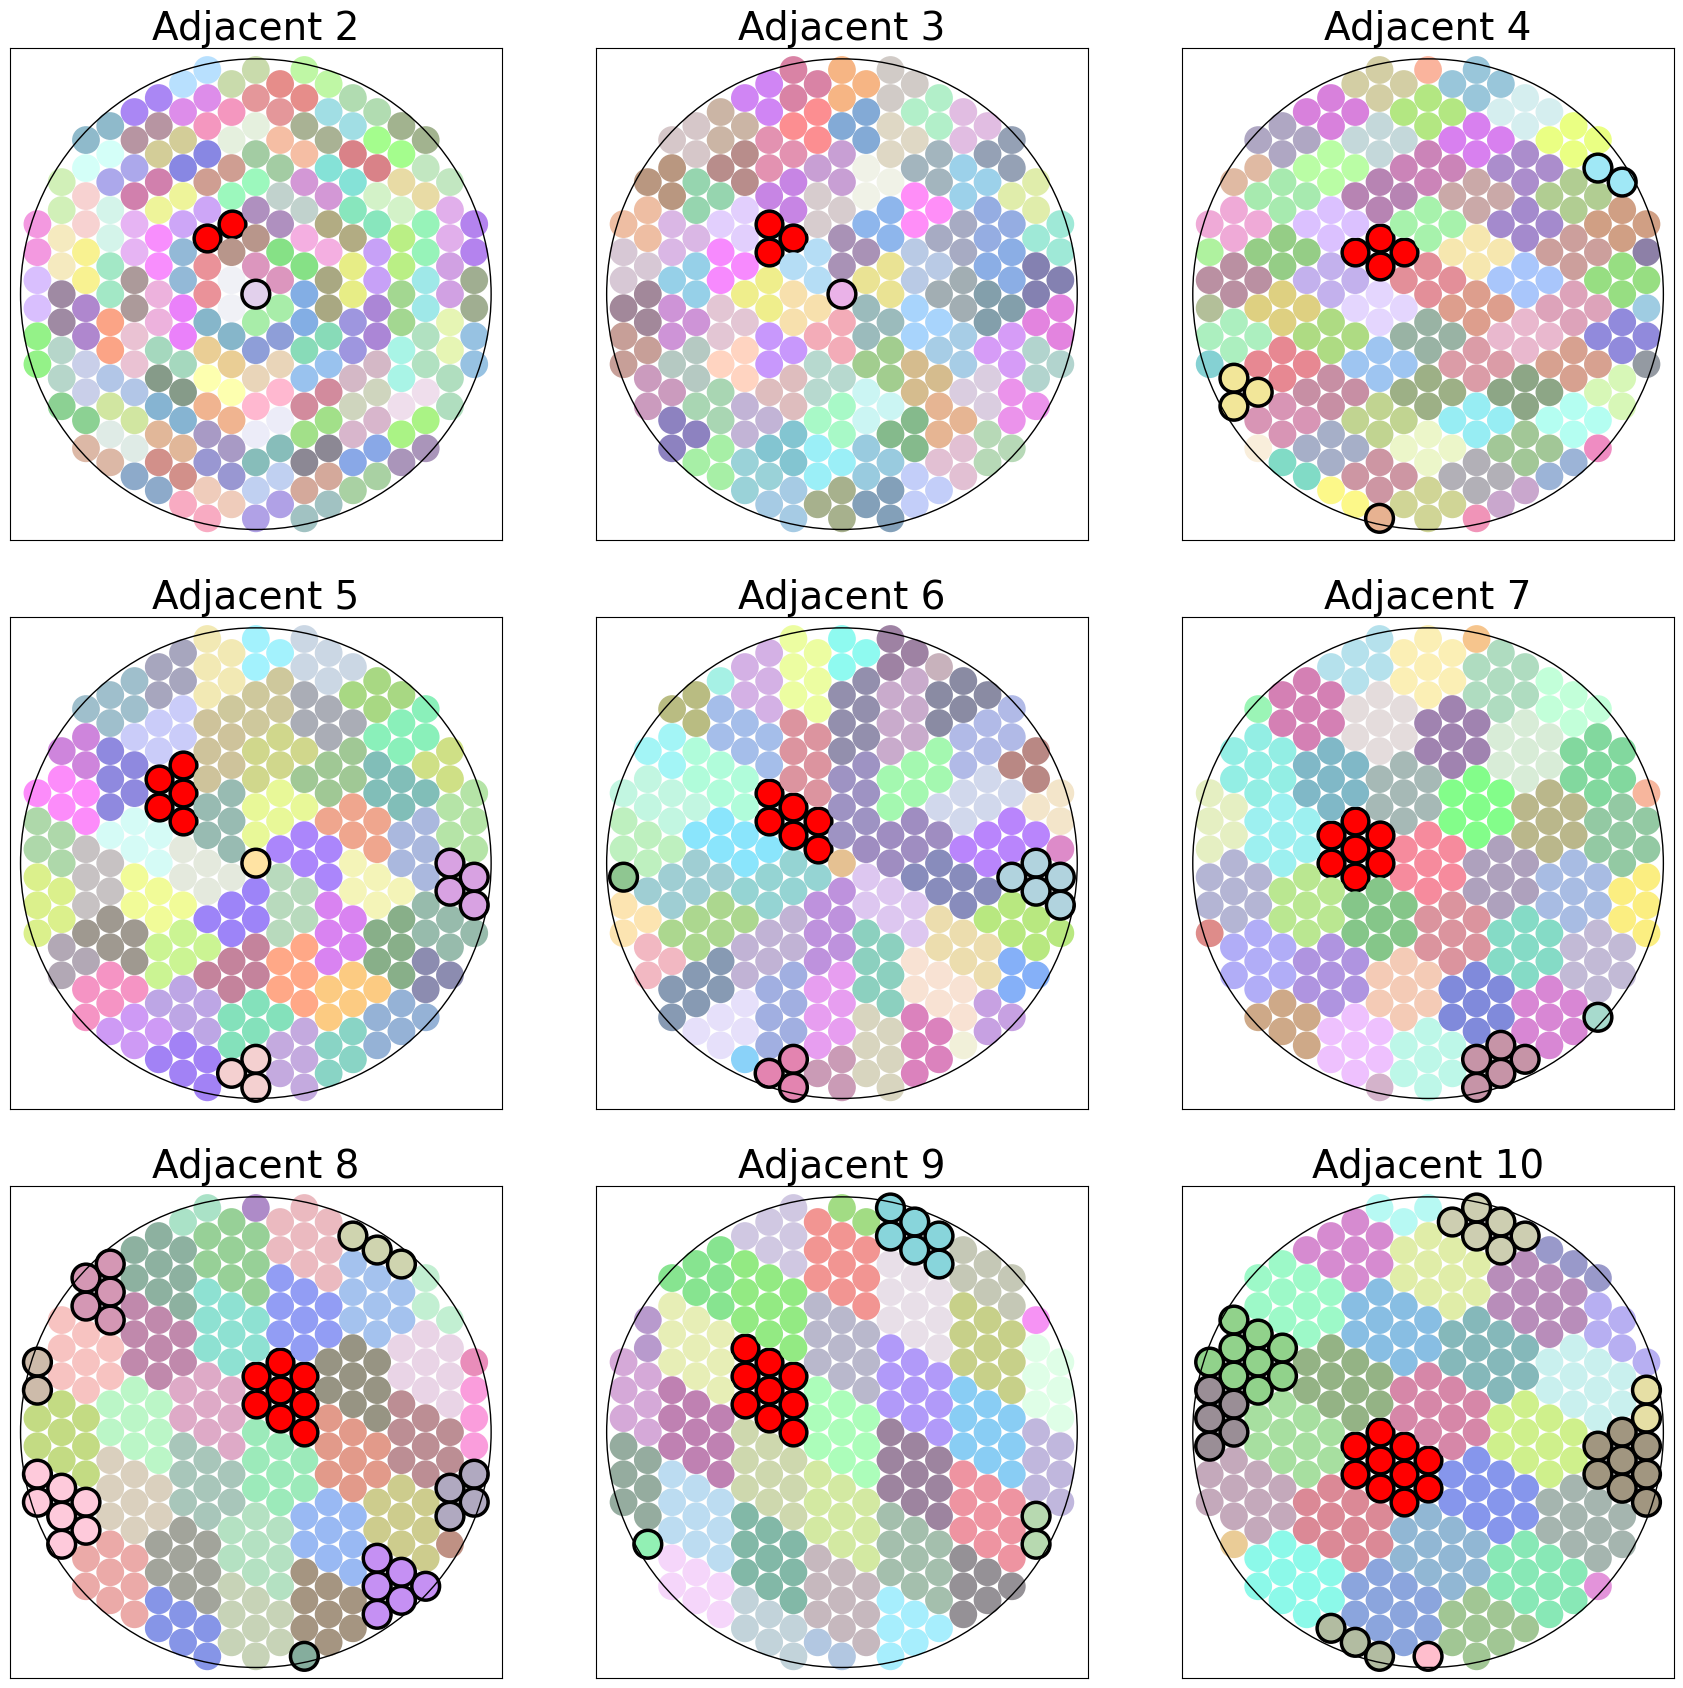

In [69]:
def plot_adjacent_grouping_grid_custom_highlight(
    mux_pattern_file,
    hex_geometry_file,
    highlight_indices,
    extra_highlight_groups=None,  # List of lists of group indices
    save_image=False,
    image_dir="/home/nkoebelin/Images"
):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    import matplotlib.colors as mcolors
    import os

    assert len(highlight_indices) == 9, "You must provide one highlight index for each of the 9 adjacent groupings (adj_2 to adj_10)."
    if extra_highlight_groups is None:
        extra_highlight_groups = [[] for _ in range(9)]
    else:
        assert len(extra_highlight_groups) == 9, "extra_highlight_groups must have one list per adjacent model."

    plt.rcParams.update({
        "font.size": 26,
        "axes.labelsize": 26,
        "axes.titlesize": 28,
        "xtick.labelsize": 23,
        "ytick.labelsize": 23,
        "legend.fontsize": 26
    })

    os.makedirs(image_dir, exist_ok=True)

    geo = np.load(hex_geometry_file, allow_pickle=True)
    pmt_x_top = geo["pmt_x_top"]
    pmt_y_top = geo["pmt_y_top"]

    mux_patterns = np.load(mux_pattern_file, allow_pickle=True)

    def generate_pastel_colors(n, darken_factor=0.85):
        import random
        pastel_colors = []
        for _ in range(n):
            base = [random.random() for _ in range(3)]
            pastel = [(1 + c) / 2 * darken_factor for c in base]
            pastel_colors.append(mcolors.to_hex(pastel))
        return pastel_colors

    fig, axes = plt.subplots(3, 3, figsize=(18, 18))

    for i, ax in enumerate(axes.flatten()):
        group_num = i + 2
        mux_name = f"adj_{group_num}"
        groups = [[int(p) for p in g if p != -1] for g in mux_patterns[mux_name]]
        highlight_idx = highlight_indices[i]
        group_indices_to_outline = extra_highlight_groups[i]

        pastel_colors = generate_pastel_colors(len(groups), darken_factor=1)

        # First plot all groups normally
        for j, group in enumerate(groups):
            x = pmt_x_top[group]
            y = pmt_y_top[group]

            # Filled group
            if j == highlight_idx:
                group_arr = np.array(groups[j])
                x = pmt_x_top[group_arr]
                y = pmt_y_top[group_arr]
                ax.scatter(x, y, c='red', edgecolors='black', s=370, linewidths=2.5, marker='o')
            else:
                group_arr = np.array(groups[j])
                x = pmt_x_top[group_arr]
                y = pmt_y_top[group_arr]
                ax.scatter(x, y, c=pastel_colors[j], edgecolors='none', s=400, marker='o')


        # Now overlay outline for extra-highlighted groups (no fill)
        for j in group_indices_to_outline:
            if j < len(groups):
                group_arr = np.array(groups[j])
                x = pmt_x_top[group_arr]
                y = pmt_y_top[group_arr]
                ax.scatter(x, y, facecolors='none', edgecolors='k', s=400, linewidths=2.5, marker='o')

        ax.set_title(f"Adjacent {group_num}", fontsize=28)
        ax.set_xlim(-70, 70)
        ax.set_ylim(-70, 70)
        ax.set_aspect('equal')
        ax.grid(alpha=0.3)
        circle = Circle((0, 0), 67, color='k', fill=False, linewidth=1)
        ax.add_patch(circle)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    if save_image:
        save_path = os.path.join(image_dir, "adjacent_grouping_layouts_custom_highlight.png")
        plt.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")

    plt.show()

highlight_list = [59, 72, 42, 36, 18, 4, 22, 19, 13]  # single group to fill red
extra_groups = [
    [126],      # for adj_2
    [84],           # for adj_3
    [0, 8, 70],# for adj_4
    [17,23,54],           # ...
    [14,0,41],
    [30, 42],
    [2, 12, 26, 37, 11, 4, 33],
    [15, 2, 35,],
    [1, 0, 15, 16, 21, 20, 31]
]

plot_adjacent_grouping_grid_custom_highlight(
    mux_pattern_file="mux_patterns_all_new.npz",
    hex_geometry_file="hex_pattern_data.npz",
    highlight_indices=highlight_list,
    extra_highlight_groups=extra_groups,
    save_image=False
)


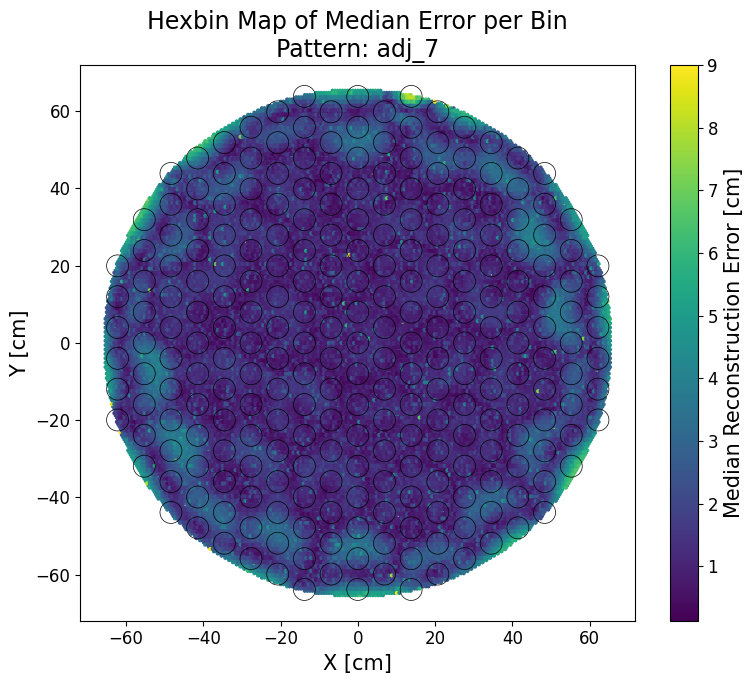

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
pattern_name = "adj_7"    # <-- Set your pattern name here
gridsize = 200            # Resolution of hexbin grid

# --- Load data ---
data_path = f"/scratch/midway3/nkoebelin/mux_data_new/saved_data_{pattern_name}.npz"
data = np.load(data_path)
pos_test = data["pos_test"]
abs_errors = data["abs_errors"]

# Load PMT positions
hex_data = np.load("hex_pattern_data.npz", allow_pickle=True)
pmt_xy_top = hex_data["pmt_xy_top"]

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Coordinates and values to plot ---
x = pos_test[:, 0]
y = pos_test[:, 1]
values = abs_errors  # The quantity to average within each bin

# --- Plot hexbin: average error per bin ---
plt.figure(figsize=(8, 7))
hb = plt.hexbin(
    x, y,
    C=values,
    reduce_C_function=np.median,
    gridsize=gridsize,
    cmap='viridis',
    mincnt=1,  # Hide empty bins
    vmax=9
)

# --- Overlay PMT positions as black circles ---
pmt_xy_top = np.array(pmt_xy_top.tolist())  # Convert list of tuples/arrays to a proper 2D array
pmt_x = pmt_xy_top[:, 0]
pmt_y = pmt_xy_top[:, 1]
plt.scatter(pmt_x, pmt_y, s=250, facecolors='none', edgecolors='black', linewidths=0.5)

# --- Colorbar ---
cbar = plt.colorbar(hb)
cbar.set_label("Median Reconstruction Error [cm]")

# --- Labels and layout ---
plt.xlabel("X [cm]")
plt.ylabel("Y [cm]")
plt.title(f"Hexbin Map of Median Error per Bin\nPattern: {pattern_name}")
plt.axis('equal')
plt.tight_layout()

# Save or show
# plt.show()
# plt.savefig(f"{pattern_name}_hexbin_median_error_with_pmt_overlay.png", dpi=300)


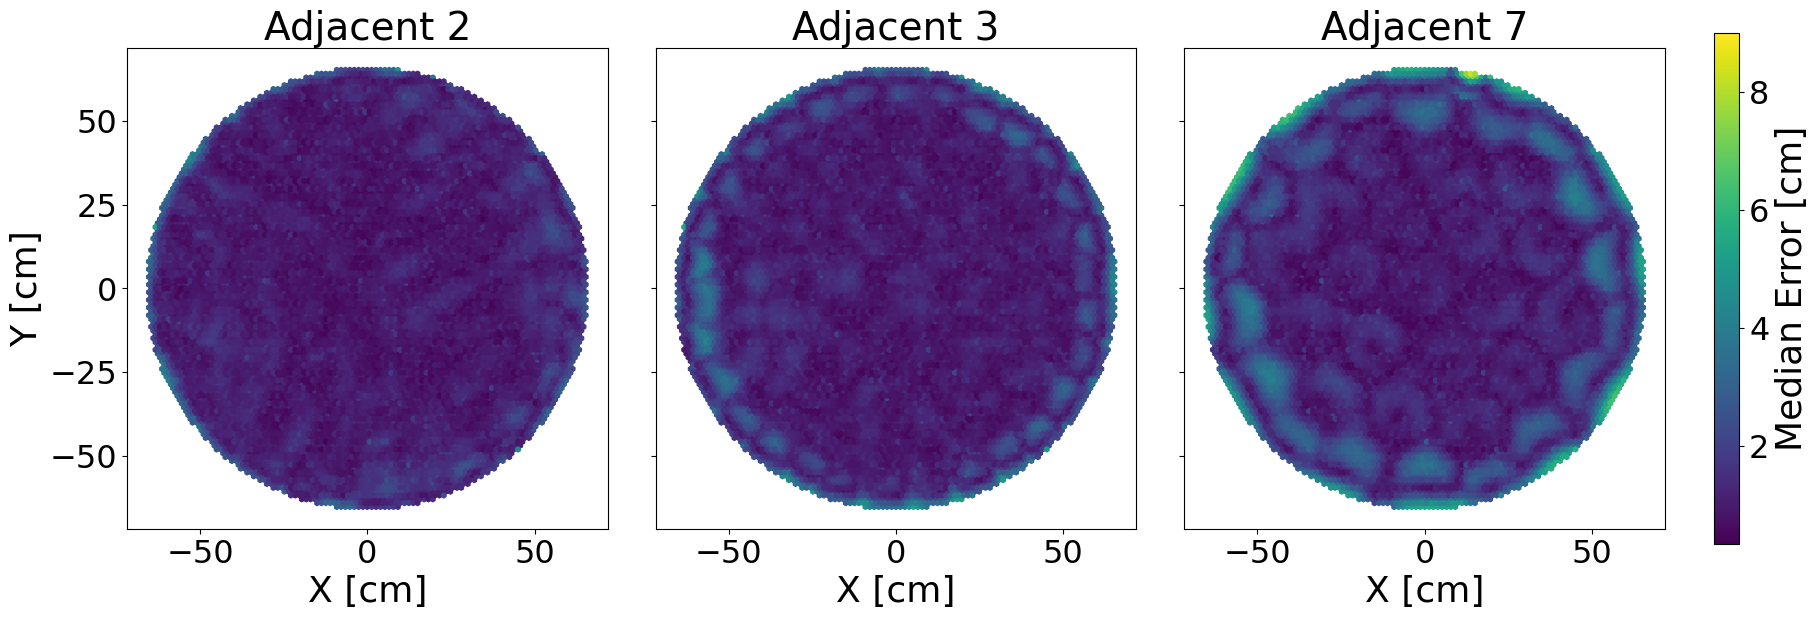

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Font size setup to match reference layout ---
plt.rcParams.update({
    "font.size": 26,
    "axes.labelsize": 26,
    "axes.titlesize": 28,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 26
})

# --- Configuration ---
patterns = ["adj_2", "adj_3", "adj_7"]
titles = ["Adjacent 2", "Adjacent 3", "Adjacent 7"]
gridsize = 100
vmax = 9

# --- Create figure and axes ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, bottom=0.12, top=0.85)

# --- Loop through each model and plot hexbin ---
for ax, pattern_name, title in zip(axes, patterns, titles):
    data_path = f"/scratch/midway3/nkoebelin/mux_data_new/saved_data_{pattern_name}.npz"
    data = np.load(data_path)
    x = data["pos_test"][:, 0]
    y = data["pos_test"][:, 1]
    values = data["abs_errors"]

    hb = ax.hexbin(
        x, y,
        C=values,
        reduce_C_function=np.median,
        gridsize=gridsize,
        cmap='viridis',
        mincnt=1,
        vmax=vmax
    )

    ax.set_title(title)
    ax.set_xlabel("X [cm]")
    if ax is axes[0]:
        ax.set_ylabel("Y [cm]")

    ax.set_aspect("equal")
    #ax.grid(alpha=0.3)

# --- Shared colorbar ---
cbar = fig.colorbar(hb, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.025, pad=0.03)
cbar.set_label("Median Error [cm]")

# --- Main title ---
#fig.suptitle("Hexbin Map of Median Error per Bin (Adjacent Models)", fontsize=16)

# --- Save or show ---
#plt.savefig("adj_hexbin_median_error_patterns237.png", dpi=300)
plt.show()


# Performance ALL

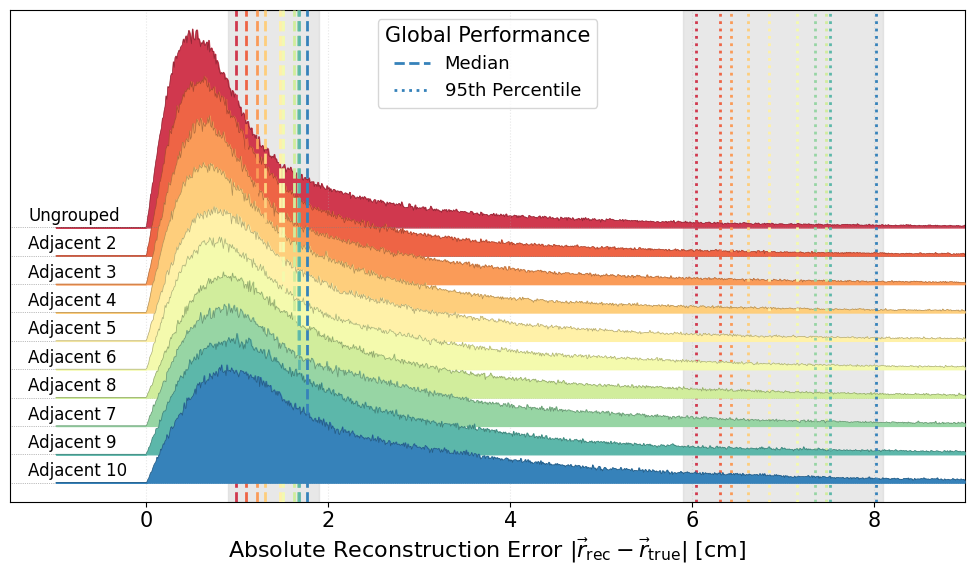

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 15,          # Base size for ticks
    "axes.labelsize": 16,     # x/y label size
    "axes.titlesize": 17,     # Title size
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15
})

# --- Load adjacent models ---
with open('/scratch/midway3/nkoebelin/mux_data_new/adjacent_model_results.pkl', 'rb') as f:
    combined_adj = pickle.load(f)

# --- Load ungrouped models ---
with open('/scratch/midway3/nkoebelin/mux_data_new/combined_results_ungrouped.pkl', 'rb') as f:
    combined_ungrouped = pickle.load(f)

# --- Area range to use ---
area_key = 'area_10_1e5'

# --- Prepare results dictionary ---
results = {}

# Add adjacent models
for model_name, area_dict in combined_adj.items():
    if area_key in area_dict:
        results[model_name] = area_dict[area_key]

# Add ungrouped_1 model
if area_key in combined_ungrouped['ungrouped_1']:
    results['ungrouped_1'] = combined_ungrouped['ungrouped_1'][area_key]

# --- Label formatter ---
def format_model_name(name):
    if name == "ungrouped_1":
        return "Ungrouped"
    match = re.match(r'adj_(\d+)', name)
    if match:
        return f"Adjacent {match.group(1)}"
    return name

# --- Plot function ---
def plot_error_ridgeline_histogram(results, bins=200, xlim=(0, 10), spacing=0.2, scale_factor=2.0, save_path=None):
    sorted_models = sorted(results.items(), key=lambda item: np.median(item[1]["abs_errors"]))
    n_models = len(sorted_models)

    fig, ax = plt.subplots(figsize=(10, n_models * 0.6))
    colors = sns.color_palette("Spectral", n_models)

    # Add vertical background bands for better line visibility
    ax.axvspan(0.9, 1.9, color='lightgray', alpha=0.5, zorder=0)
    ax.axvspan(5.9, 8.1, color='lightgray', alpha=0.5, zorder=0)



    max_height = 0
    histograms = []

    # Precompute histograms
    for model_name, data in sorted_models:
        abs_errors = data["abs_errors"]
        abs_errors = abs_errors[abs_errors <= xlim[1]]

        counts, bin_edges = np.histogram(abs_errors, bins=bins, range=xlim, density=True)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        histograms.append((model_name, bin_centers, counts))
        max_height = max(max_height, counts.max())

    # Plot from top to bottom
    for i, (model_name, bin_centers, counts) in enumerate(reversed(histograms)):
        y_shift = i * spacing
        z = n_models - i
        color_idx = n_models - 1 - i

        # Fill under histogram
        ax.fill_between(bin_centers, y_shift, counts * spacing * scale_factor / max_height + y_shift,
                        color=colors[color_idx], alpha=1.0, zorder=z)

        # Line
        ax.plot(bin_centers, counts * spacing * scale_factor / max_height + y_shift,
                color=tuple(np.array(colors[color_idx]) * 0.7), lw=0.5, zorder=z)

        # Baseline
        ax.axhline(y=y_shift, color='gray', linestyle=':', linewidth=0.5)

        # Median and 95th percentile
        abs_errors = results[model_name]["abs_errors"]
        median = np.median(abs_errors)
        p95 = np.percentile(abs_errors, 95)

        median_label = 'Median' if i == 0 else None
        p95_label = '95th Percentile' if i == 0 else None

        ax.axvline(median, color=colors[color_idx], linestyle='--', lw=2.0, zorder=z + 0.1, label=median_label)
        ax.axvline(p95, color=colors[color_idx], linestyle=':', lw=2.0, zorder=z + 0.1, label=p95_label)

        # Text label
        model_label = format_model_name(model_name)
        ax.text(xlim[0] - 0.3, y_shift + 0.06, model_label, ha='left', va='center', fontsize=12)

    # Formatting
    ax.set_xlim(xlim[0] - 0.5, xlim[1])
    ax.set_ylim(-0.1, n_models * spacing + 1.0)
    ax.set_xlabel(r"Absolute Reconstruction Error $|\vec{r}_\mathrm{rec} - \vec{r}_\mathrm{true}|$ [cm]")
    ax.set_yticks([])
    ax.legend(title="Global Performance", loc='upper center', fontsize=13, frameon=True, fancybox=True)
    ax.grid(axis='x', linestyle=':', alpha=0.3)
    plt.tight_layout()
    #plt.subplots_adjust(left=-0.5)  # or try 0.3 if needed

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# --- Run plot ---
plot_error_ridgeline_histogram(results, bins=1000, xlim=(-1.0, 9), spacing=0.15, scale_factor=7.0)#, save_path="adjacent_all_ridgeline.png")


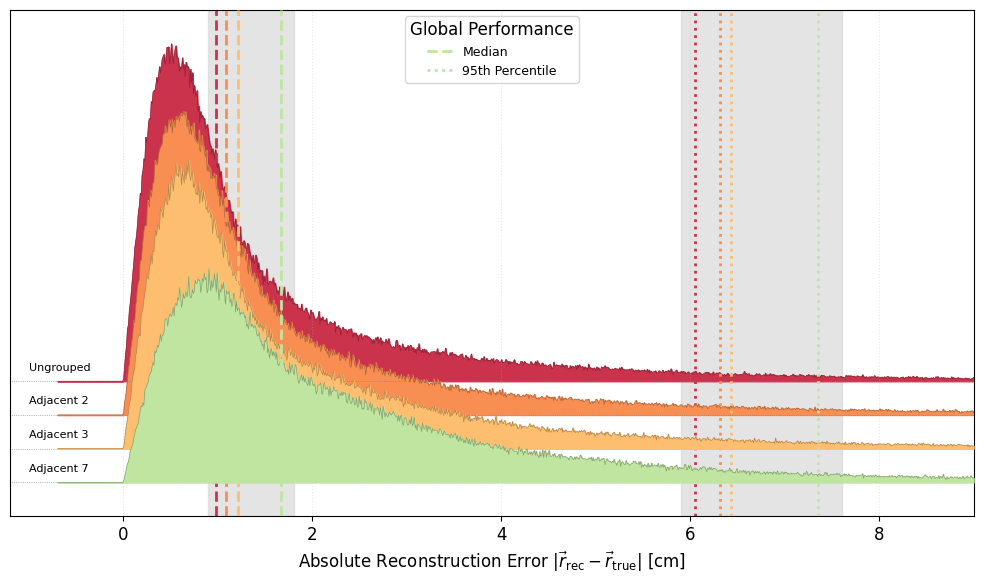

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Load adjacent models ---
with open('/scratch/midway3/nkoebelin/mux_data_new/adjacent_model_results.pkl', 'rb') as f:
    combined_adj = pickle.load(f)

# --- Load ungrouped models ---
with open('/scratch/midway3/nkoebelin/mux_data_new/combined_results_ungrouped.pkl', 'rb') as f:
    combined_ungrouped = pickle.load(f)

# --- Area range to use ---
area_key = 'area_10_1e5'

# --- Define consistent model order and color palette ---
full_model_order = ['ungrouped_1'] + [f'adj_{i}' for i in range(1, 11)]
full_colors = sns.color_palette("Spectral", len(full_model_order))

# --- Prepare filtered results dictionary ---
included_models = ['ungrouped_1', 'adj_2', 'adj_3', 'adj_7']
results = {}

# Add selected adjacent models
for model_name in included_models:
    if model_name.startswith('adj_') and model_name in combined_adj:
        area_dict = combined_adj[model_name]
        if area_key in area_dict:
            results[model_name] = area_dict[area_key]

# Add selected ungrouped model
if 'ungrouped_1' in included_models and area_key in combined_ungrouped['ungrouped_1']:
    results['ungrouped_1'] = combined_ungrouped['ungrouped_1'][area_key]

# --- Label formatter ---
def format_model_name(name):
    if name == "ungrouped_1":
        return "Ungrouped"
    match = re.match(r'adj_(\d+)', name)
    if match:
        return f"Adjacent {match.group(1)}"
    return name

# --- Plot function ---
def plot_error_ridgeline_histogram(results, bins=200, xlim=(0, 10), spacing=0.2, scale_factor=2.0, save_path=None):
    sorted_models = sorted(results.items(), key=lambda item: np.median(item[1]["abs_errors"]))
    n_models = len(sorted_models)

    fig, ax = plt.subplots(figsize=(10, n_models * 1.5))

    max_height = 0
    histograms = []

    # Precompute histograms
    for model_name, data in sorted_models:
        abs_errors = data["abs_errors"]
        abs_errors = abs_errors[abs_errors <= xlim[1]]

        counts, bin_edges = np.histogram(abs_errors, bins=bins, range=xlim, density=True)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        histograms.append((model_name, bin_centers, counts))
        max_height = max(max_height, counts.max())

    # Plot from top to bottom
    for i, (model_name, bin_centers, counts) in enumerate(reversed(histograms)):
        y_shift = i * spacing
        z = n_models - i

        color_idx = full_model_order.index(model_name)
        color = full_colors[color_idx]

        # Fill under histogram
        ax.fill_between(bin_centers, y_shift, counts * spacing * scale_factor / max_height + y_shift,
                        color=color, alpha=1.0, zorder=z)

        # Line
        ax.plot(bin_centers, counts * spacing * scale_factor / max_height + y_shift,
                color=tuple(np.array(color) * 0.7), lw=0.5, zorder=z)

        # Baseline
        ax.axhline(y=y_shift, color='gray', linestyle=':', linewidth=0.5)

        # Median and 95th percentile
        abs_errors = results[model_name]["abs_errors"]
        median = np.median(abs_errors)
        p95 = np.percentile(abs_errors, 95)

        median_label = 'Median' if i == 0 else None
        p95_label = '95th Percentile' if i == 0 else None

        ax.axvline(median, color=color, linestyle='--', lw=2.0, zorder=z + 0.1, label=median_label)
        ax.axvline(p95, color=color, linestyle=':', lw=2.0, zorder=z + 0.1, label=p95_label)

        # Text label
        model_label = format_model_name(model_name)
        ax.text(xlim[0] - 0.3, y_shift + 0.04, model_label, ha='left', va='center', fontsize=8)

    # Background highlight regions
    ax.axvspan(0.9, 1.8, color='lightgray', alpha=0.6, zorder=0)
    ax.axvspan(5.9, 7.6, color='lightgray', alpha=0.6, zorder=0)

    # Formatting
    ax.set_xlim(xlim[0] - 0.5, xlim[1])
    ax.set_ylim(-0.1, n_models * spacing + 1.0)
    ax.set_xlabel(r"Absolute Reconstruction Error $|\vec{r}_\mathrm{rec} - \vec{r}_\mathrm{true}|$ [cm]", fontsize=12)
    ax.set_yticks([])
    ax.legend(title="Global Performance", loc='upper center', fontsize=9, frameon=True, fancybox=True)
    ax.grid(axis='x', linestyle=':', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# --- Run plot ---
plot_error_ridgeline_histogram(results, bins=1000, xlim=(-0.7, 9), spacing=0.1, scale_factor=10.0)


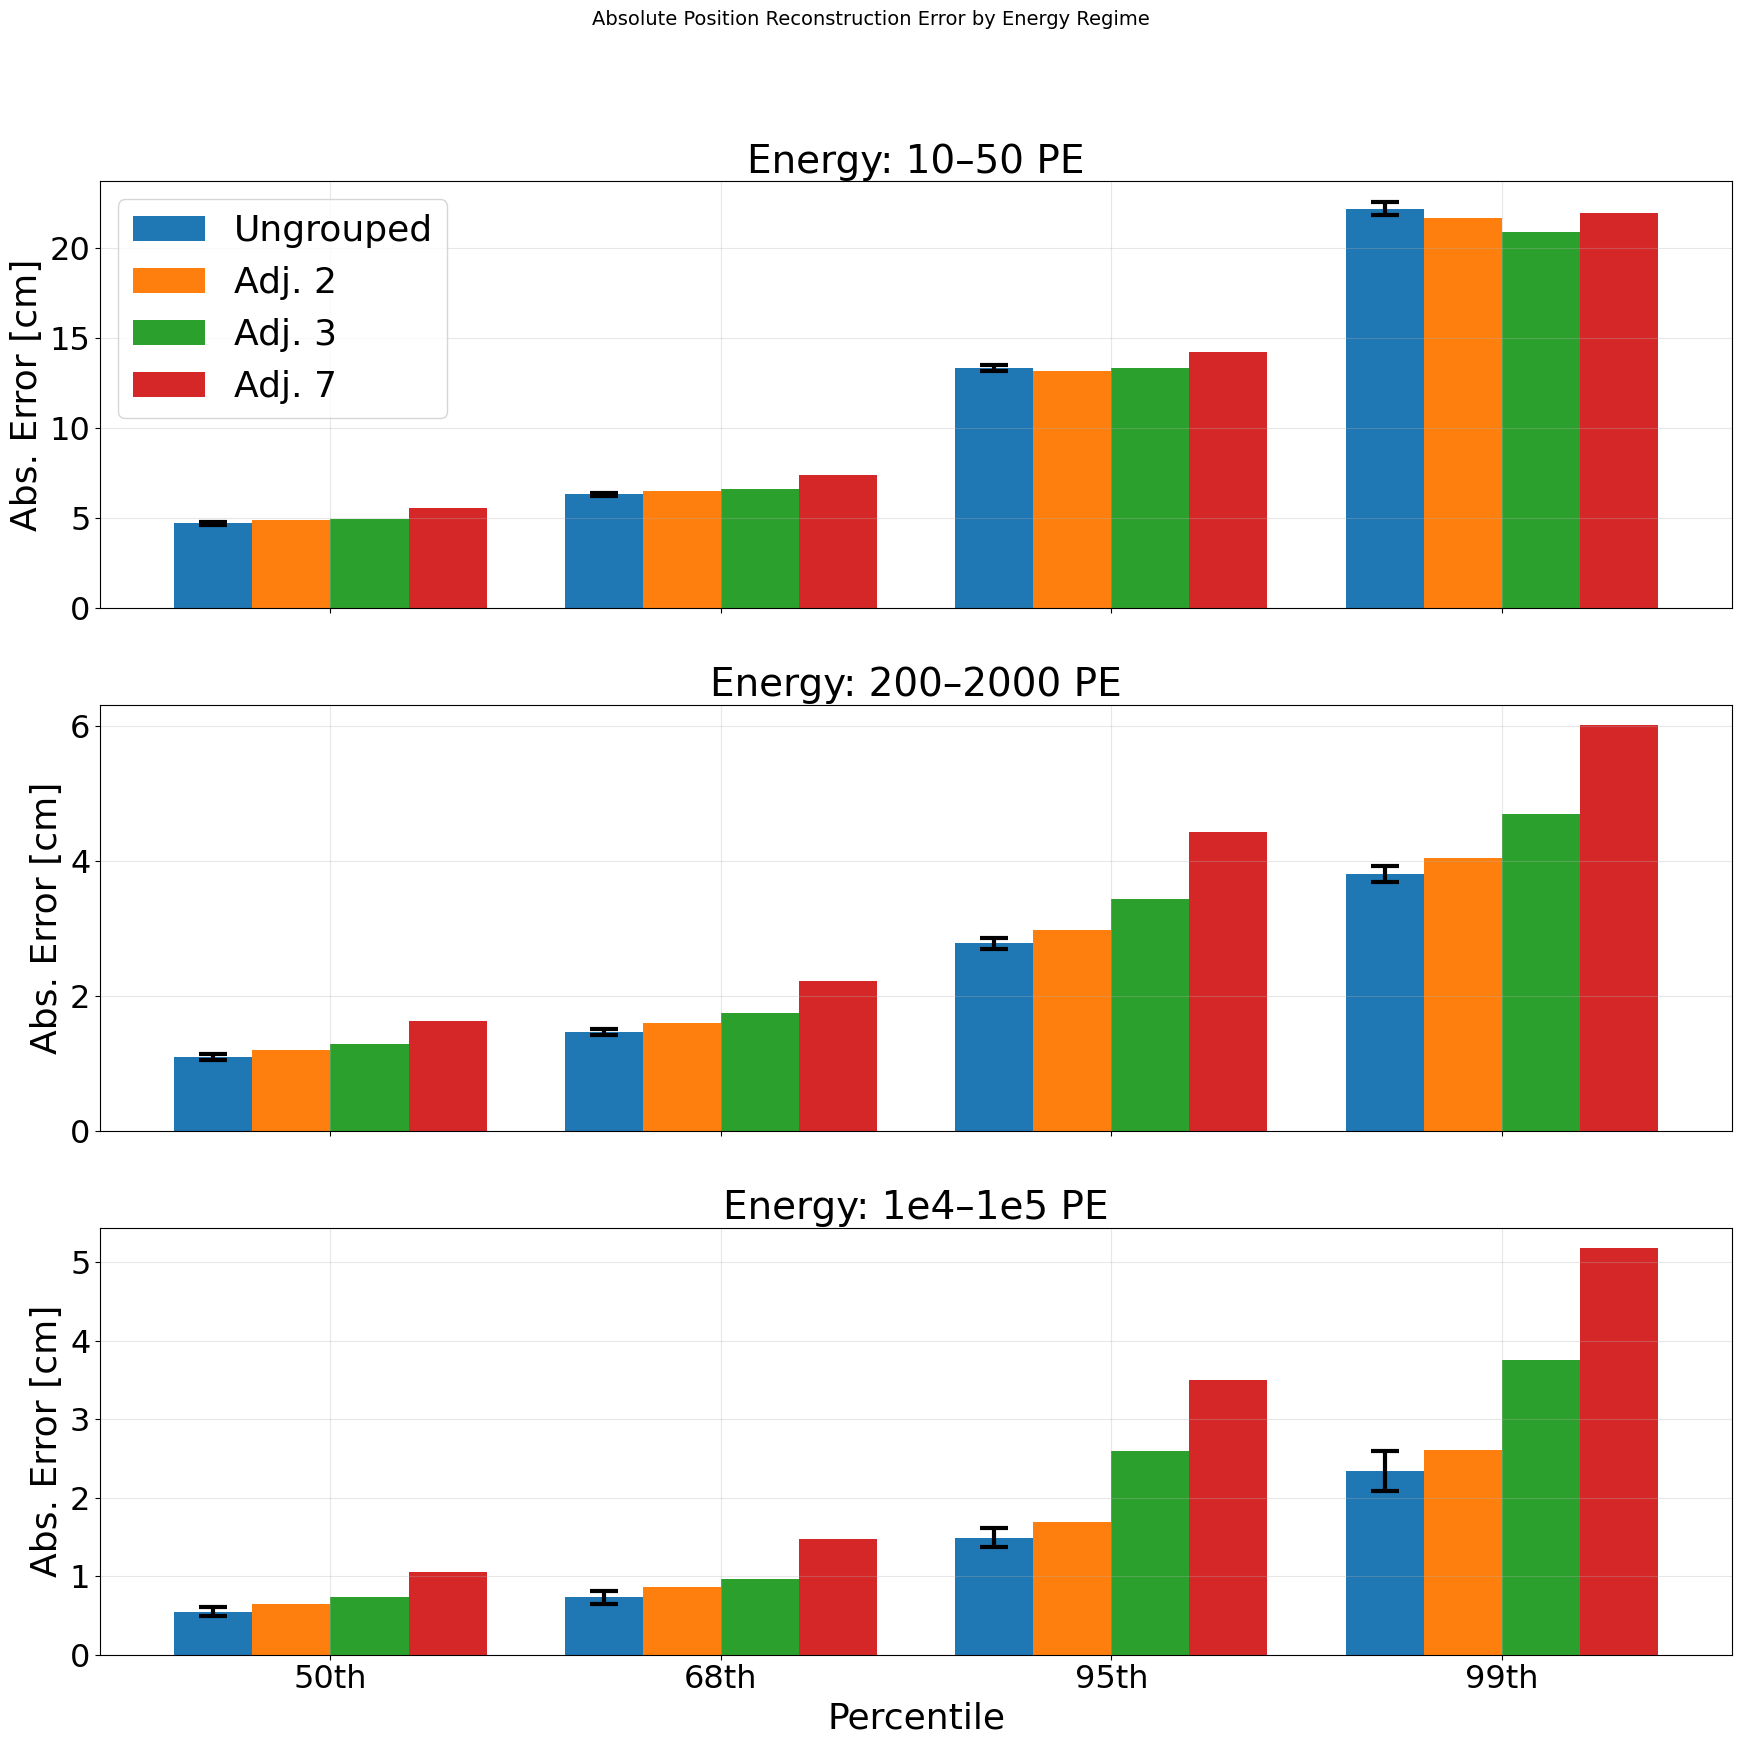

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# --- Labels and Models ---
models = ['Ungrouped', 'Adj. 2', 'Adj. 3', 'Adj. 7']
percentiles = ['50th', '68th', '95th', '99th']
x = np.arange(len(percentiles))
width = 0.2

plt.rcParams.update({
    "font.size": 26,
    "axes.labelsize": 26,
    "axes.titlesize": 28,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 26
})

# --- Data: error values (in cm) ---
data = {
    '10–50 PE': [
        [4.71, 4.88, 4.96, 5.55],   # 50th
        [6.34, 6.53, 6.60, 7.40],   # 68th
        [13.32, 13.20, 13.32, 14.24],  # 95th
        [22.20, 21.67, 20.89, 21.93],  # 99th
    ],
    '200–2000 PE': [
        [1.10, 1.20, 1.29, 1.64],
        [1.47, 1.60, 1.75, 2.23],
        [2.78, 2.98, 3.43, 4.42],
        [3.81, 4.04, 4.70, 6.01],
    ],
    '1e4–1e5 PE': [
        [0.55, 0.65, 0.73, 1.05],
        [0.73, 0.86, 0.97, 1.47],
        [1.49, 1.69, 2.59, 3.50],
        [2.34, 2.61, 3.75, 5.18],
    ]
}

# --- Baseline uncertainties (for Ungrouped model only) ---
baseline_errs = {
    '10–50 PE': [0.08, 0.08, 0.17, 0.38],
    '200–2000 PE': [0.04, 0.04, 0.08, 0.12],
    '1e4–1e5 PE': [0.06, 0.08, 0.12, 0.26]
}

# --- Plotting setup ---
fig, axes = plt.subplots(3, 1, figsize=(18, 18), sharex=True)
#colors = ['grey', 'C0', 'C2', 'C1']
colors = ['C0', 'C1', 'C2', 'C3']

for ax, (regime, values) in zip(axes, data.items()):
    values = np.array(values).T  # shape: (4 models, 4 percentiles)
    
    for i in range(len(models)):
        yerr = baseline_errs[regime] if i == 0 else None
        ax.bar(x + i*width - 1.5*width, values[i], width,
               label=models[i], color=colors[i], yerr=yerr,
               capsize=10, error_kw={"elinewidth": 3, "capthick": 3})#, edgecolor='k' if i == 0 else None)

    ax.set_ylabel("Abs. Error [cm]")
    ax.set_title(f"Energy: {regime}")
    ax.grid(True, alpha=0.3)
    #ax.legend(fontsize=10)

axes[0].legend()
# Shared X-axis
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(percentiles)
axes[-1].set_xlabel("Percentile")

# Global title and layout
plt.suptitle("Absolute Position Reconstruction Error by Energy Regime", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig("abs_err_adj237_barplot.png", dpi=300)
plt.show()


In [11]:
import pickle

# Load the results
with open('/scratch/midway3/nkoebelin/mux_data_new/adjacent_model_results.pkl', 'rb') as f:
    combined_results = pickle.load(f)

# Area key to extract
area_key = 'area_10_1e5'

# Expected adjacent models (adj_2 to adj_10)
model_names = [f"adj_{i}" for i in range(2, 11)]

# Print header
print(f"{'Model':<10} | {'Median':>7} | {'68th':>7} | {'90th':>7} | {'95th':>7} | {'99th':>7}")
print("-" * 55)

# Print each model's stats
for model in model_names:
    if model not in combined_results:
        print(f"{model:<10} | Missing from results")
        continue
    if area_key not in combined_results[model]:
        print(f"{model:<10} | Area range missing")
        continue

    stats = combined_results[model][area_key]
    median = stats['median_error']
    p68 = stats['68th_percentile']
    p90 = stats['90th_percentile']
    p95 = stats['95th_percentile']
    p99 = stats['99th_percentile']

    print(f"{model:<10} | {median:7.3f} | {p68:7.3f} | {p90:7.3f} | {p95:7.3f} | {p99:7.3f}")


Model      |  Median |    68th |    90th |    95th |    99th
-------------------------------------------------------
adj_2      |   1.090 |   1.737 |   4.346 |   6.309 |  11.651
adj_3      |   1.214 |   2.010 |   4.538 |   6.430 |  11.716
adj_4      |   1.301 |   2.051 |   4.613 |   6.618 |  12.037
adj_5      |   1.464 |   2.309 |   4.893 |   6.845 |  12.179
adj_6      |   1.496 |   2.395 |   5.239 |   7.157 |  12.614
adj_7      |   1.664 |   2.605 |   5.367 |   7.353 |  12.734
adj_8      |   1.621 |   2.531 |   5.495 |   7.474 |  13.111
adj_9      |   1.678 |   2.566 |   5.342 |   7.518 |  13.222
adj_10     |   1.760 |   2.825 |   5.895 |   8.017 |  13.841


In [9]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import wofz
import pickle

# --- Voigt profile definition ---
def voigt(x, x0, sigma, gamma, A):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# --- Summary function ---
def summarize(name, fits, fwhms):
    print(f"\n{name} FIT RESULTS (mean ± SEM  [SD]  {{max dev}}):")
    param_names = ["μ", "σ", "γ", "A"]
    for i, pname in enumerate(param_names):
        vals = fits[:, i]
        mean = np.nanmean(vals)
        std = np.nanstd(vals)
        sem = std / np.sqrt(np.sum(~np.isnan(vals)))
        max_dev = np.nanmax(np.abs(vals - mean))
        print(f"{pname}: {mean:.3f} ± {sem:.3f}  [{std:.3f}]  {{{max_dev:.3f}}}")
    fwhm_mean = np.nanmean(fwhms)
    fwhm_std = np.nanstd(fwhms)
    fwhm_sem = fwhm_std / np.sqrt(np.sum(~np.isnan(fwhms)))
    fwhm_max_dev = np.nanmax(np.abs(fwhms - fwhm_mean))
    print(f"FWHM: {fwhm_mean:.3f} ± {fwhm_sem:.3f}  [{fwhm_std:.3f}]  {{{fwhm_max_dev:.3f}}}")

# --- Load adjacent model results (single-run) ---
with open('/scratch/midway3/nkoebelin/mux_data_new/adjacent_model_results.pkl', 'rb') as f:
    combined_adj = pickle.load(f)

# --- Choose models and area range ---
models = ['adj_2', 'adj_3', 'adj_7']
area_key = 'area_10_1e5'
bins = np.linspace(-6, 6, 1000)

# --- Analyze each model ---
for model in models:
    print(f"\n--- Analyzing {model} ---")
    data = combined_adj[model][area_key]
    pos_test = data["pos_test"]
    pos_pred = data["pos_pred"]
    abs_errors = data["abs_errors"]

    delta = pos_pred - pos_test
    delta_x = delta[:, 0]
    delta_y = delta[:, 1]

    results_x = []
    results_y = []
    fwhms_x = []
    fwhms_y = []

    for delta_vals, result_list, fwhm_list, label in zip(
        [delta_x, delta_y],
        [results_x, results_y],
        [fwhms_x, fwhms_y],
        ["Δx", "Δy"]
    ):
        counts, edges = np.histogram(delta_vals, bins=bins)
        centers = 0.5 * (edges[:-1] + edges[1:])
        sigma_y = np.sqrt(np.maximum(counts, 1))

        # Fit Voigt profile
        p0 = [0, 1, 1, max(counts)]
        try:
            popt, _ = curve_fit(voigt, centers, counts, p0=p0, sigma=sigma_y, absolute_sigma=True)
            result_list.append(popt)

            x0, sigma, gamma, A = popt
            fwhm = 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2.35482 * sigma)**2)
            fwhm_list.append(fwhm)
        except RuntimeError:
            print(f"Voigt fit failed for {model} {label}")
            result_list.append([np.nan] * 4)
            fwhm_list.append(np.nan)

    summarize(f"{model} Δx", np.array(results_x), np.array(fwhms_x))
    summarize(f"{model} Δy", np.array(results_y), np.array(fwhms_y))



--- Analyzing adj_2 ---

adj_2 Δx FIT RESULTS (mean ± SEM  [SD]  {max dev}):
μ: 0.141 ± 0.000  [0.000]  {0.000}
σ: 0.256 ± 0.000  [0.000]  {0.000}
γ: 0.610 ± 0.000  [0.000]  {0.000}
A: 4693.617 ± 0.000  [0.000]  {0.000}
FWHM: 1.480 ± 0.000  [0.000]  {0.000}

adj_2 Δy FIT RESULTS (mean ± SEM  [SD]  {max dev}):
μ: 0.206 ± 0.000  [0.000]  {0.000}
σ: 0.242 ± 0.000  [0.000]  {0.000}
γ: 0.600 ± 0.000  [0.000]  {0.000}
A: 4700.089 ± 0.000  [0.000]  {0.000}
FWHM: 1.439 ± 0.000  [0.000]  {0.000}

--- Analyzing adj_3 ---

adj_3 Δx FIT RESULTS (mean ± SEM  [SD]  {max dev}):
μ: 0.064 ± 0.000  [0.000]  {0.000}
σ: 0.223 ± 0.000  [0.000]  {0.000}
γ: 0.732 ± 0.000  [0.000]  {0.000}
A: 4733.013 ± 0.000  [0.000]  {0.000}
FWHM: 1.643 ± 0.000  [0.000]  {0.000}

adj_3 Δy FIT RESULTS (mean ± SEM  [SD]  {max dev}):
μ: 0.131 ± 0.000  [0.000]  {0.000}
σ: 0.295 ± 0.000  [0.000]  {0.000}
γ: 0.683 ± 0.000  [0.000]  {0.000}
A: 4739.030 ± 0.000  [0.000]  {0.000}
FWHM: 1.673 ± 0.000  [0.000]  {0.000}

--- Analyzing

In [10]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import wofz
import pickle
import os

# --- Voigt profile definition ---
def voigt(x, x0, sigma, gamma, A):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# --- Summary function ---
def summarize(name, fits, fwhms):
    print(f"\n{name} FIT RESULTS (mean ± SEM  [SD]  {{max dev}}):")
    param_names = ["μ", "σ", "γ", "A"]
    for i, pname in enumerate(param_names):
        vals = fits[:, i]
        mean = np.nanmean(vals)
        std = np.nanstd(vals)
        sem = std / np.sqrt(np.sum(~np.isnan(vals)))
        max_dev = np.nanmax(np.abs(vals - mean))
        print(f"{pname}: {mean:.3f} ± {sem:.3f}  [{std:.3f}]  {{{max_dev:.3f}}}")
    fwhm_mean = np.nanmean(fwhms)
    fwhm_std = np.nanstd(fwhms)
    fwhm_sem = fwhm_std / np.sqrt(np.sum(~np.isnan(fwhms)))
    fwhm_max_dev = np.nanmax(np.abs(fwhms - fwhm_mean))
    print(f"FWHM: {fwhm_mean:.3f} ± {fwhm_sem:.3f}  [{fwhm_std:.3f}]  {{{fwhm_max_dev:.3f}}}")

# --- Fitting helper ---
def fit_voigt(delta_vals, bins):
    counts, edges = np.histogram(delta_vals, bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])
    sigma_y = np.sqrt(np.maximum(counts, 1))

    p0 = [0, 1, 1, max(counts)]
    try:
        popt, _ = curve_fit(voigt, centers, counts, p0=p0, sigma=sigma_y, absolute_sigma=True)
        x0, sigma, gamma, A = popt
        fwhm = 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2.35482 * sigma)**2)
        return popt, fwhm
    except RuntimeError:
        return [np.nan] * 4, np.nan

# --- Configuration ---
base_path = "/scratch/midway3/nkoebelin/mux_data_new/"
ungrouped_prefix = "saved_data_ungrouped_"
n_ungrouped = 10
adj_models = ["adj_2", "adj_3", "adj_7"]
area_key = 'area_10_1e5'
bins = np.linspace(-6, 6, 1000)

# --- Fit ungrouped models (10 runs) ---
fit_results_x = []
fit_results_y = []
fwhms_x = []
fwhms_y = []

for i in range(1, n_ungrouped + 1):
    file_path = os.path.join(base_path, f"{ungrouped_prefix}{i}.npz")
    data = np.load(file_path)

    pos_test = data["pos_test"]
    pos_pred = data["pos_pred"]
    abs_errors = data["abs_errors"]

    delta = pos_pred - pos_test
    delta_x = delta[:, 0]
    delta_y = delta[:, 1]

    for delta_vals, results, fwhms in zip([delta_x, delta_y], [fit_results_x, fit_results_y], [fwhms_x, fwhms_y]):
        popt, fwhm = fit_voigt(delta_vals, bins)
        results.append(popt)
        fwhms.append(fwhm)

# --- Summarize ungrouped ---
fit_results_x = np.array(fit_results_x)
fit_results_y = np.array(fit_results_y)
fwhms_x = np.array(fwhms_x)
fwhms_y = np.array(fwhms_y)

summarize("Ungrouped Δx", fit_results_x, fwhms_x)
summarize("Ungrouped Δy", fit_results_y, fwhms_y)

# --- Load adjacent model results from .pkl ---
with open(os.path.join(base_path, "adjacent_model_results.pkl"), "rb") as f:
    combined_adj = pickle.load(f)

# --- Fit and summarize adjacent models ---
for model in adj_models:
    print(f"\n--- Analyzing {model} ---")
    data = combined_adj[model][area_key]
    pos_test = data["pos_test"]
    pos_pred = data["pos_pred"]

    delta = pos_pred - pos_test
    delta_x = delta[:, 0]
    delta_y = delta[:, 1]

    results_x, fwhms_x = [], []
    results_y, fwhms_y = [], []

    for delta_vals, results, fwhms, label in zip(
        [delta_x, delta_y],
        [results_x, results_y],
        [fwhms_x, fwhms_y],
        ["Δx", "Δy"]
    ):
        popt, fwhm = fit_voigt(delta_vals, bins)
        results.append(popt)
        fwhms.append(fwhm)

    summarize(f"{model} Δx", np.array(results_x), np.array(fwhms_x))
    summarize(f"{model} Δy", np.array(results_y), np.array(fwhms_y))


/scratch/local/jobs/32633511/ipykernel_1831071/4237487631.py:10: RuntimeWarning: overflow encountered in multiply
  return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))



Ungrouped Δx FIT RESULTS (mean ± SEM  [SD]  {max dev}):
μ: 0.050 ± 0.034  [0.107]  {0.186}
σ: 0.167 ± 0.030  [0.095]  {0.167}
γ: 0.576 ± 0.004  [0.013]  {0.024}
A: 4682.387 ± 1.915  [6.055]  {13.614}
FWHM: 1.309 ± 0.036  [0.115]  {0.192}

Ungrouped Δy FIT RESULTS (mean ± SEM  [SD]  {max dev}):
μ: -0.043 ± 0.025  [0.078]  {0.153}
σ: 0.145 ± 0.029  [0.093]  {0.168}
γ: 0.551 ± 0.003  [0.010]  {0.018}
A: 4678.995 ± 1.757  [5.557]  {10.680}
FWHM: 1.233 ± 0.036  [0.114]  {0.269}

--- Analyzing adj_2 ---

adj_2 Δx FIT RESULTS (mean ± SEM  [SD]  {max dev}):
μ: 0.141 ± 0.000  [0.000]  {0.000}
σ: 0.256 ± 0.000  [0.000]  {0.000}
γ: 0.610 ± 0.000  [0.000]  {0.000}
A: 4693.617 ± 0.000  [0.000]  {0.000}
FWHM: 1.480 ± 0.000  [0.000]  {0.000}

adj_2 Δy FIT RESULTS (mean ± SEM  [SD]  {max dev}):
μ: 0.206 ± 0.000  [0.000]  {0.000}
σ: 0.242 ± 0.000  [0.000]  {0.000}
γ: 0.600 ± 0.000  [0.000]  {0.000}
A: 4700.089 ± 0.000  [0.000]  {0.000}
FWHM: 1.439 ± 0.000  [0.000]  {0.000}

--- Analyzing adj_3 ---

ad

In [12]:
import numpy as np
import os
import pickle

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
n_ungrouped = 10
adj_models = ["adj_2", "adj_3", "adj_7"]
area_ranges = [
    (10, 50, "area_10_50"),
    (200, 2000, "area_200_2000"),
    (1e4, 1e5, "area_1e4_1e5"),
]

percentiles = [50, 68, 95, 99]

# --- Load adjacent model results ---
with open(os.path.join(data_dir, "adjacent_model_results.pkl"), "rb") as f:
    combined_adj = pickle.load(f)

def compute_percentiles(errors):
    return {p: np.percentile(errors, p) for p in percentiles}

def get_ungrouped_avg_percentiles(area_min, area_max):
    all_errors = []
    for i in range(1, n_ungrouped + 1):
        file_path = os.path.join(data_dir, f"saved_data_ungrouped_{i}.npz")
        with np.load(file_path) as data:
            mask = (data["area_test"] >= area_min) & (data["area_test"] <= area_max)
            abs_errors = data["abs_errors"][mask]
            all_errors.append(abs_errors)
    all_errors = np.concatenate(all_errors)
    return compute_percentiles(all_errors)

def get_adjacent_percentiles(model, area_key):
    data = combined_adj[model][area_key]
    return compute_percentiles(data["abs_errors"])

# --- Run comparison ---
for area_min, area_max, area_key in area_ranges:
    baseline = get_ungrouped_avg_percentiles(area_min, area_max)

    print(f"\n=== {area_key} ===")
    for model in adj_models:
        adj = get_adjacent_percentiles(model, area_key)
        print(f"\nModel: {model}")
        for p in percentiles:
            print(f"{p}th percentile: Ungrouped = {baseline[p]:.3f} cm, {model} = {adj[p]:.3f} cm")



=== area_10_50 ===

Model: adj_2
50th percentile: Ungrouped = 4.710 cm, adj_2 = 4.879 cm
68th percentile: Ungrouped = 6.344 cm, adj_2 = 6.525 cm
95th percentile: Ungrouped = 13.322 cm, adj_2 = 13.201 cm
99th percentile: Ungrouped = 22.208 cm, adj_2 = 21.672 cm

Model: adj_3
50th percentile: Ungrouped = 4.710 cm, adj_3 = 4.955 cm
68th percentile: Ungrouped = 6.344 cm, adj_3 = 6.596 cm
95th percentile: Ungrouped = 13.322 cm, adj_3 = 13.317 cm
99th percentile: Ungrouped = 22.208 cm, adj_3 = 20.892 cm

Model: adj_7
50th percentile: Ungrouped = 4.710 cm, adj_7 = 5.551 cm
68th percentile: Ungrouped = 6.344 cm, adj_7 = 7.397 cm
95th percentile: Ungrouped = 13.322 cm, adj_7 = 14.237 cm
99th percentile: Ungrouped = 22.208 cm, adj_7 = 21.927 cm

=== area_200_2000 ===

Model: adj_2
50th percentile: Ungrouped = 1.100 cm, adj_2 = 1.203 cm
68th percentile: Ungrouped = 1.472 cm, adj_2 = 1.597 cm
95th percentile: Ungrouped = 2.784 cm, adj_2 = 2.983 cm
99th percentile: Ungrouped = 3.810 cm, adj_2 = 4.

In [13]:
import numpy as np
import os
import pickle

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
n_ungrouped = 10
adj_models = ["adj_2", "adj_3", "adj_7"]

# --- Area ranges with exact keys used in saved data ---
area_ranges = [
    (10, 50, "area_10_50"),
    (200, 2000, "area_200_2000"),
    (1e4, 1e5, "area_1e4_1e5"),
]

percentiles = [50, 68, 95, 99]

# --- Load adjacent model results ---
with open(os.path.join(data_dir, "adjacent_model_results.pkl"), "rb") as f:
    combined_adj = pickle.load(f)

# --- Percentile helper ---
def compute_percentiles(errors):
    return {p: np.percentile(errors, p) for p in percentiles}

# --- Load ungrouped averaged percentiles across 10 runs ---
def get_ungrouped_avg_percentiles(area_min, area_max):
    all_errors = []
    for i in range(1, n_ungrouped + 1):
        path = os.path.join(data_dir, f"saved_data_ungrouped_{i}.npz")
        with np.load(path) as data:
            mask = (data["area_test"] >= area_min) & (data["area_test"] <= area_max)
            abs_errors = data["abs_errors"][mask]
            all_errors.append(abs_errors)
    all_errors = np.concatenate(all_errors)
    return compute_percentiles(all_errors)

# --- Load adjacent model percentiles ---
def get_adjacent_percentiles(model, area_key):
    data = combined_adj[model][area_key]
    return compute_percentiles(data["abs_errors"])

# --- Run comparison ---
for area_min, area_max, area_key in area_ranges:
    baseline = get_ungrouped_avg_percentiles(area_min, area_max)

    print(f"\n=== Energy Range: {area_key.replace('_', ' ')} ===")
    print("Ungrouped (average over 10 runs):")
    for p in percentiles:
        print(f"  {p}th percentile: {baseline[p]:.3f} cm")

    for model in adj_models:
        adj = get_adjacent_percentiles(model, area_key)
        print(f"\nModel: {model}")
        for p in percentiles:
            print(f"  {p}th percentile: {adj[p]:.3f} cm")



=== Energy Range: area 10 50 ===
Ungrouped (average over 10 runs):
  50th percentile: 4.710 cm
  68th percentile: 6.344 cm
  95th percentile: 13.322 cm
  99th percentile: 22.208 cm

Model: adj_2
  50th percentile: 4.879 cm
  68th percentile: 6.525 cm
  95th percentile: 13.201 cm
  99th percentile: 21.672 cm

Model: adj_3
  50th percentile: 4.955 cm
  68th percentile: 6.596 cm
  95th percentile: 13.317 cm
  99th percentile: 20.892 cm

Model: adj_7
  50th percentile: 5.551 cm
  68th percentile: 7.397 cm
  95th percentile: 14.237 cm
  99th percentile: 21.927 cm

=== Energy Range: area 200 2000 ===
Ungrouped (average over 10 runs):
  50th percentile: 1.100 cm
  68th percentile: 1.472 cm
  95th percentile: 2.784 cm
  99th percentile: 3.810 cm

Model: adj_2
  50th percentile: 1.203 cm
  68th percentile: 1.597 cm
  95th percentile: 2.983 cm
  99th percentile: 4.042 cm

Model: adj_3
  50th percentile: 1.289 cm
  68th percentile: 1.746 cm
  95th percentile: 3.426 cm
  99th percentile: 4.695 cm

In [14]:
import numpy as np
import os
import pickle

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
n_ungrouped = 10
adj_models = ["adj_2", "adj_3", "adj_7"]

# --- Area ranges (matching keys used in saved data) ---
area_ranges = [
    (10, 50, "area_10_50"),
    (200, 2000, "area_200_2000"),
    (1e4, 1e5, "area_1e4_1e5"),
]

percentiles = [50, 68, 95, 99]

# --- Load adjacent model results ---
with open(os.path.join(data_dir, "adjacent_model_results.pkl"), "rb") as f:
    combined_adj = pickle.load(f)

# --- Percentile helper ---
def compute_percentiles(errors):
    return {p: np.percentile(errors, p) for p in percentiles}

# --- Load ungrouped average percentiles + uncertainties ---
def get_ungrouped_avg_percentiles(area_min, area_max):
    percentile_runs = {p: [] for p in percentiles}

    for i in range(1, n_ungrouped + 1):
        path = os.path.join(data_dir, f"saved_data_ungrouped_{i}.npz")
        with np.load(path) as data:
            mask = (data["area_test"] >= area_min) & (data["area_test"] <= area_max)
            abs_errors = data["abs_errors"][mask]
            for p in percentiles:
                percentile_runs[p].append(np.percentile(abs_errors, p))

    result = {}
    for p in percentiles:
        values = np.array(percentile_runs[p])
        mean = np.mean(values)
        max_dev = np.max(np.abs(values - mean))
        result[p] = (mean, max_dev)
    return result

# --- Load adjacent model percentiles ---
def get_adjacent_percentiles(model, area_key):
    data = combined_adj[model][area_key]
    return compute_percentiles(data["abs_errors"])

# --- Run comparison ---
for area_min, area_max, area_key in area_ranges:
    baseline = get_ungrouped_avg_percentiles(area_min, area_max)

    print(f"\n=== Energy Range: {area_key.replace('_', ' ')} ===")
    print("Ungrouped (10-run average ± max deviation):")
    for p in percentiles:
        mean, max_dev = baseline[p]
        print(f"  {p}th percentile: {mean:.3f} ± {max_dev:.3f} cm")

    for model in adj_models:
        adj = get_adjacent_percentiles(model, area_key)
        print(f"\nModel: {model}")
        for p in percentiles:
            print(f"  {p}th percentile: {adj[p]:.3f} cm")



=== Energy Range: area 10 50 ===
Ungrouped (10-run average ± max deviation):
  50th percentile: 4.711 ± 0.082 cm
  68th percentile: 6.343 ± 0.084 cm
  95th percentile: 13.319 ± 0.168 cm
  99th percentile: 22.201 ± 0.380 cm

Model: adj_2
  50th percentile: 4.879 cm
  68th percentile: 6.525 cm
  95th percentile: 13.201 cm
  99th percentile: 21.672 cm

Model: adj_3
  50th percentile: 4.955 cm
  68th percentile: 6.596 cm
  95th percentile: 13.317 cm
  99th percentile: 20.892 cm

Model: adj_7
  50th percentile: 5.551 cm
  68th percentile: 7.397 cm
  95th percentile: 14.237 cm
  99th percentile: 21.927 cm

=== Energy Range: area 200 2000 ===
Ungrouped (10-run average ± max deviation):
  50th percentile: 1.100 ± 0.037 cm
  68th percentile: 1.472 ± 0.043 cm
  95th percentile: 2.783 ± 0.080 cm
  99th percentile: 3.805 ± 0.117 cm

Model: adj_2
  50th percentile: 1.203 cm
  68th percentile: 1.597 cm
  95th percentile: 2.983 cm
  99th percentile: 4.042 cm

Model: adj_3
  50th percentile: 1.289 cm

In [4]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
ungrouped_models = [f"ungrouped_{i}" for i in range(1, 11)]
adj_models = ["adj_2", "adj_3", "adj_7"]

split_ranges = [
    (10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE'),
    (1e4, 1e5, '1e4–1e5 PE')
]

percentiles_to_compute = [50, 68, 95, 99]

# --- Helper for ungrouped models ---
def compute_ungrouped_stats(area_min, area_max):
    signed_vals = {p: [] for p in percentiles_to_compute}
    abs_vals = {p: [] for p in percentiles_to_compute}

    for model in ungrouped_models:
        path = os.path.join(data_dir, f"saved_data_{model}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            area = data["area_test"]
            radial = data["radial_errors"]
        mask = (area >= area_min) & (area <= area_max)
        if not np.any(mask):
            continue
        for p in percentiles_to_compute:
            signed_vals[p].append(np.percentile(radial[mask], p))
            abs_vals[p].append(np.percentile(np.abs(radial[mask]), p))

    signed_stats = {
        p: (np.mean(signed_vals[p]), np.max(np.abs(signed_vals[p] - np.mean(signed_vals[p]))))
        for p in percentiles_to_compute
    }
    abs_stats = {
        p: (np.mean(abs_vals[p]), np.max(np.abs(abs_vals[p] - np.mean(abs_vals[p]))))
        for p in percentiles_to_compute
    }
    return signed_stats, abs_stats

# --- Helper for adjacent models ---
def compute_adjacent_stats(model, area_min, area_max):
    path = os.path.join(data_dir, f"saved_data_{model}.npz")
    if not os.path.exists(path):
        return None, None
    with np.load(path) as data:
        area = data["area_test"]
        radial = data["radial_errors"]
    mask = (area >= area_min) & (area <= area_max)
    if not np.any(mask):
        return None, None
    signed_stats = {
        p: (np.percentile(radial[mask], p), 0.0)
        for p in percentiles_to_compute
    }
    abs_stats = {
        p: (np.percentile(np.abs(radial[mask]), p), 0.0)
        for p in percentiles_to_compute
    }
    return signed_stats, abs_stats

# --- Main loop ---
for area_min, area_max, label in split_ranges:
    print(f"\n=== Energy Range: {label} ===")

    # Ungrouped
    signed_u, abs_u = compute_ungrouped_stats(area_min, area_max)
    print("\nUngrouped (averaged over 10 runs):")
    for p in percentiles_to_compute:
        print(f"Signed {p}th: {signed_u[p][0]:.3f} ± {signed_u[p][1]:.3f} cm")
    for p in percentiles_to_compute:
        print(f"Abs {p}th:    {abs_u[p][0]:.3f} ± {abs_u[p][1]:.3f} cm")

    # Adjacent models
    for model in adj_models:
        signed_a, abs_a = compute_adjacent_stats(model, area_min, area_max)
        print(f"\nModel: {model}")
        if signed_a is None:
            print("  Data not found.")
            continue
        for p in percentiles_to_compute:
            print(f"Signed {p}th: {signed_a[p][0]:.3f} cm")
        for p in percentiles_to_compute:
            print(f"Abs {p}th:    {abs_a[p][0]:.3f} cm")



=== Energy Range: 10–50 PE ===

Ungrouped (averaged over 10 runs):
Signed 50th: -0.186 ± 0.189 cm
Signed 68th: 1.646 ± 0.194 cm
Signed 95th: 6.673 ± 0.258 cm
Signed 99th: 10.642 ± 0.398 cm
Abs 50th:    2.712 ± 0.046 cm
Abs 68th:    4.107 ± 0.037 cm
Abs 95th:    9.682 ± 0.075 cm
Abs 99th:    16.188 ± 0.286 cm

Model: adj_2
Signed 50th: -0.420 cm
Signed 68th: 1.416 cm
Signed 95th: 6.435 cm
Signed 99th: 10.452 cm
Abs 50th:    2.717 cm
Abs 68th:    4.118 cm
Abs 95th:    9.549 cm
Abs 99th:    15.588 cm

Model: adj_3
Signed 50th: -0.438 cm
Signed 68th: 1.483 cm
Signed 95th: 6.710 cm
Signed 99th: 10.459 cm
Abs 50th:    2.849 cm
Abs 68th:    4.318 cm
Abs 95th:    9.783 cm
Abs 99th:    15.474 cm

Model: adj_7
Signed 50th: -0.374 cm
Signed 68th: 1.803 cm
Signed 95th: 7.707 cm
Signed 99th: 11.585 cm
Abs 50th:    3.241 cm
Abs 68th:    4.906 cm
Abs 95th:    10.822 cm
Abs 99th:    16.879 cm

=== Energy Range: 200–2000 PE ===

Ungrouped (averaged over 10 runs):
Signed 50th: 0.062 ± 0.157 cm
Signed 6

In [8]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
ungrouped_models = [f"ungrouped_{i}" for i in range(1, 11)]
adj_models = ["adj_2", "adj_3", "adj_7"]

split_ranges = [
    (10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE'),
    (1e4, 1e5, '1e4–1e5 PE')
]

# --- Ungrouped wall leakage analysis ---
print("=== Wall Leakage Percentages ===")
for area_min, area_max, area_label in split_ranges:
    percentages = []

    for model_key in ungrouped_models:
        path = os.path.join(data_dir, f"saved_data_{model_key}.npz")
        if not os.path.exists(path):
            continue

        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                continue

            pos_test = data["pos_test"]
            pos_pred = data["pos_pred"]
            area = data["area_test"]

        mask_area = (area >= area_min) & (area <= area_max)
        r_true = np.linalg.norm(pos_test[mask_area], axis=1)
        r_pred = np.linalg.norm(pos_pred[mask_area], axis=1)

        mask_outer = r_true >= 60
        mask_leak = r_pred[mask_outer] < 60

        if np.sum(mask_outer) > 0:
            percent = 100 * np.sum(mask_leak) / np.sum(mask_outer)
            percentages.append(percent)

    if percentages:
        avg = np.mean(percentages)
        max_dev = np.max(np.abs(np.array(percentages) - avg))
        print(f"\nUngrouped ({area_label}): {avg:.2f}% ± {max_dev:.2f}% of events with r_true ≥ 60 cm have r_pred < 60 cm")
    else:
        print(f"\nUngrouped ({area_label}): No valid data across training runs.")

# --- Adjacent model comparison ---
for area_min, area_max, area_label in split_ranges:
    for model in adj_models:
        path = os.path.join(data_dir, f"saved_data_{model}.npz")
        if not os.path.exists(path):
            print(f"{model} ({area_label}): File not found.")
            continue

        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                print(f"{model} ({area_label}): Required keys not found in file.")
                continue

            pos_test = data["pos_test"]
            pos_pred = data["pos_pred"]
            area = data["area_test"]

        mask_area = (area >= area_min) & (area <= area_max)
        r_true = np.linalg.norm(pos_test[mask_area], axis=1)
        r_pred = np.linalg.norm(pos_pred[mask_area], axis=1)

        mask_outer = r_true >= 60
        mask_leak = r_pred[mask_outer] < 60

        if np.sum(mask_outer) > 0:
            percent = 100 * np.sum(mask_leak) / np.sum(mask_outer)
            print(f"{model} ({area_label}): {percent:.2f}% of events with r_true ≥ 60 cm have r_pred < 60 cm")
        else:
            print(f"{model} ({area_label}): No outer events to evaluate.")


=== Wall Leakage Percentages ===

Ungrouped (10–50 PE): 44.24% ± 1.95% of events with r_true ≥ 60 cm have r_pred < 60 cm

Ungrouped (200–2000 PE): 4.16% ± 0.81% of events with r_true ≥ 60 cm have r_pred < 60 cm

Ungrouped (1e4–1e5 PE): 0.74% ± 0.61% of events with r_true ≥ 60 cm have r_pred < 60 cm
adj_2 (10–50 PE): 44.17% of events with r_true ≥ 60 cm have r_pred < 60 cm
adj_3 (10–50 PE): 49.60% of events with r_true ≥ 60 cm have r_pred < 60 cm
adj_7 (10–50 PE): 53.64% of events with r_true ≥ 60 cm have r_pred < 60 cm
adj_2 (200–2000 PE): 4.89% of events with r_true ≥ 60 cm have r_pred < 60 cm
adj_3 (200–2000 PE): 7.97% of events with r_true ≥ 60 cm have r_pred < 60 cm
adj_7 (200–2000 PE): 25.15% of events with r_true ≥ 60 cm have r_pred < 60 cm
adj_2 (1e4–1e5 PE): 1.45% of events with r_true ≥ 60 cm have r_pred < 60 cm
adj_3 (1e4–1e5 PE): 2.03% of events with r_true ≥ 60 cm have r_pred < 60 cm
adj_7 (1e4–1e5 PE): 17.37% of events with r_true ≥ 60 cm have r_pred < 60 cm


In [6]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
ungrouped_models = [f"ungrouped_{i}" for i in range(1, 11)]
adj_models = ["adj_2", "adj_3", "adj_7"]
wall_threshold = 60  # cm
r_cut_scan = np.arange(55, 70, 0.01)

split_ranges = [
    (10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE'),
    (1e4, 1e5, '1e4–1e5 PE')
]

# --- Helper to get leakage rate ---
def compute_leakage(pos_test, pos_pred, area, area_min, area_max, wall_thr=wall_threshold, r_cut=None):
    mask_area = (area >= area_min) & (area <= area_max)
    r_true = np.linalg.norm(pos_test[mask_area], axis=1)
    r_pred = np.linalg.norm(pos_pred[mask_area], axis=1)

    mask_outer = r_true >= wall_thr
    if r_cut is None:
        # Use default leakage definition (r_pred < wall_thr)
        mask_leak = r_pred[mask_outer] < wall_thr
    else:
        # Custom r_cut
        mask_leak = r_pred[mask_outer] < r_cut

    n_outer = np.sum(mask_outer)
    n_leak = np.sum(mask_leak)
    if n_outer == 0:
        return None
    return 100 * n_leak / n_outer

# --- Compute reference leakage for ungrouped ---
ungrouped_leakage = {}

for area_min, area_max, area_label in split_ranges:
    rates = []
    for model_key in ungrouped_models:
        path = os.path.join(data_dir, f"saved_data_{model_key}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                continue
            leakage = compute_leakage(data["pos_test"], data["pos_pred"], data["area_test"],
                                      area_min, area_max, wall_threshold)
            if leakage is not None:
                rates.append(leakage)

    if rates:
        avg = np.mean(rates)
        max_dev = np.max(np.abs(np.array(rates) - avg))
        ungrouped_leakage[area_label] = avg
        print(f"\nUngrouped ({area_label}): {avg:.2f}% ± {max_dev:.2f}% leakage (r_true ≥ {wall_threshold})")
    else:
        print(f"\nUngrouped ({area_label}): No valid data across training runs.")

# --- Find matching r_cut for adjacent models ---
print("\n=== Matched Leakage r_cut values for Adjacent Models ===")
for area_min, area_max, area_label in split_ranges:
    ref_leakage = ungrouped_leakage.get(area_label)
    if ref_leakage is None:
        continue

    for model in adj_models:
        path = os.path.join(data_dir, f"saved_data_{model}.npz")
        if not os.path.exists(path):
            print(f"{model} ({area_label}): File not found.")
            continue

        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                print(f"{model} ({area_label}): Missing keys.")
                continue

            pos_test = data["pos_test"]
            pos_pred = data["pos_pred"]
            area = data["area_test"]

            # Scan for best r_cut
            best_r_cut = None
            min_diff = np.inf
            for r_cut in r_cut_scan:
                leakage = compute_leakage(pos_test, pos_pred, area,
                                          area_min, area_max, wall_thr=r_cut,
                                          r_cut=r_cut)
                if leakage is None:
                    continue
                diff = abs(leakage - ref_leakage)
                if diff < min_diff:
                    min_diff = diff
                    best_r_cut = r_cut

            if best_r_cut is not None:
                print(f"{model} ({area_label}): r_cut = {best_r_cut:.2f} cm → leakage ≈ {ref_leakage:.2f}%")
            else:
                print(f"{model} ({area_label}): Could not determine r_cut.")



Ungrouped (10–50 PE): 44.24% ± 1.95% leakage (r_true ≥ 60)

Ungrouped (200–2000 PE): 4.16% ± 0.81% leakage (r_true ≥ 60)

Ungrouped (1e4–1e5 PE): 0.74% ± 0.61% leakage (r_true ≥ 60)

=== Matched Leakage r_cut values for Adjacent Models ===
adj_2 (10–50 PE): r_cut = 60.01 cm → leakage ≈ 44.24%
adj_3 (10–50 PE): r_cut = 59.70 cm → leakage ≈ 44.24%
adj_7 (10–50 PE): r_cut = 58.84 cm → leakage ≈ 44.24%
adj_2 (200–2000 PE): r_cut = 59.37 cm → leakage ≈ 4.16%
adj_3 (200–2000 PE): r_cut = 59.70 cm → leakage ≈ 4.16%
adj_7 (200–2000 PE): r_cut = 58.10 cm → leakage ≈ 4.16%
adj_2 (1e4–1e5 PE): r_cut = 56.28 cm → leakage ≈ 0.74%
adj_3 (1e4–1e5 PE): r_cut = 59.86 cm → leakage ≈ 0.74%
adj_7 (1e4–1e5 PE): r_cut = 58.62 cm → leakage ≈ 0.74%


In [10]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
ungrouped_models = [f"ungrouped_{i}" for i in range(1, 11)]
adj_models = ["adj_2", "adj_3", "adj_7"]
wall_threshold = 62  # cm
r_cut_scan = np.arange(50, 70, 0.01)

split_ranges = [
    (10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE'),
    (1e4, 1e5, '1e4–1e5 PE')
]

# --- Helper to get leakage rate ---
def compute_leakage(pos_test, pos_pred, area, area_min, area_max, wall_thr=wall_threshold, r_cut=None):
    mask_area = (area >= area_min) & (area <= area_max)
    r_true = np.linalg.norm(pos_test[mask_area], axis=1)
    r_pred = np.linalg.norm(pos_pred[mask_area], axis=1)

    mask_outer = r_true >= wall_thr
    if r_cut is None:
        # Use default leakage definition (r_pred < wall_thr)
        mask_leak = r_pred[mask_outer] < wall_thr
    else:
        # Custom r_cut
        mask_leak = r_pred[mask_outer] < r_cut

    n_outer = np.sum(mask_outer)
    n_leak = np.sum(mask_leak)
    if n_outer == 0:
        return None
    return 100 * n_leak / n_outer

# --- Compute reference leakage for ungrouped ---
ungrouped_leakage = {}

for area_min, area_max, area_label in split_ranges:
    rates = []
    for model_key in ungrouped_models:
        path = os.path.join(data_dir, f"saved_data_{model_key}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                continue
            leakage = compute_leakage(data["pos_test"], data["pos_pred"], data["area_test"],
                                      area_min, area_max, wall_threshold)
            if leakage is not None:
                rates.append(leakage)

    if rates:
        avg = np.mean(rates)
        max_dev = np.max(np.abs(np.array(rates) - avg))
        ungrouped_leakage[area_label] = avg
        print(f"\nUngrouped ({area_label}): {avg:.2f}% ± {max_dev:.2f}% leakage (r_true ≥ {wall_threshold})")
    else:
        print(f"\nUngrouped ({area_label}): No valid data across training runs.")

# --- Find matching r_cut for adjacent models ---
print("\n=== Matched Leakage r_cut values for Adjacent Models ===")
for area_min, area_max, area_label in split_ranges:
    ref_leakage = ungrouped_leakage.get(area_label)
    if ref_leakage is None:
        continue

    for model in adj_models:
        path = os.path.join(data_dir, f"saved_data_{model}.npz")
        if not os.path.exists(path):
            print(f"{model} ({area_label}): File not found.")
            continue

        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                print(f"{model} ({area_label}): Missing keys.")
                continue

            pos_test = data["pos_test"]
            pos_pred = data["pos_pred"]
            area = data["area_test"]

            # Scan for best r_cut
            best_r_cut = None
            min_diff = np.inf
            for r_cut in r_cut_scan:
                leakage = compute_leakage(pos_test, pos_pred, area,
                                          area_min, area_max, wall_thr=r_cut,
                                          r_cut=r_cut)
                if leakage is None:
                    continue
                diff = abs(leakage - ref_leakage)
                if diff < min_diff:
                    min_diff = diff
                    best_r_cut = r_cut

            if best_r_cut is not None:
                print(f"{model} ({area_label}): r_cut = {best_r_cut:.2f} cm → leakage ≈ {ref_leakage:.2f}%")
            else:
                print(f"{model} ({area_label}): Could not determine r_cut.")



Ungrouped (10–50 PE): 60.98% ± 2.15% leakage (r_true ≥ 62)

Ungrouped (200–2000 PE): 17.18% ± 4.40% leakage (r_true ≥ 62)

Ungrouped (1e4–1e5 PE): 4.85% ± 2.80% leakage (r_true ≥ 62)

=== Matched Leakage r_cut values for Adjacent Models ===
adj_2 (10–50 PE): r_cut = 61.88 cm → leakage ≈ 60.98%
adj_3 (10–50 PE): r_cut = 61.47 cm → leakage ≈ 60.98%
adj_7 (10–50 PE): r_cut = 60.86 cm → leakage ≈ 60.98%
adj_2 (200–2000 PE): r_cut = 61.76 cm → leakage ≈ 17.18%
adj_3 (200–2000 PE): r_cut = 61.31 cm → leakage ≈ 17.18%
adj_7 (200–2000 PE): r_cut = 59.54 cm → leakage ≈ 17.18%
adj_2 (1e4–1e5 PE): r_cut = 61.45 cm → leakage ≈ 4.85%
adj_3 (1e4–1e5 PE): r_cut = 60.90 cm → leakage ≈ 4.85%
adj_7 (1e4–1e5 PE): r_cut = 59.22 cm → leakage ≈ 4.85%


In [9]:
((60**2*np.pi)-(55**2*np.pi))/(60**2*np.pi)

0.15972222222222213

In [2]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
ungrouped_models = [f"ungrouped_{i}" for i in range(1, 11)]
adj_models = ["adj_2", "adj_3", "adj_7"]
r_cut_scan = np.arange(45, 65, 0.01)

split_ranges = [
    (10, 50, '10–50 PE'),
    (200, 2000, '200–2000 PE'),
    (1e4, 1e5, '1e4–1e5 PE')
]

# --- Leakage helper ---
def compute_leakage(pos_test, pos_pred, area, area_min, area_max, wall_thr, r_cut):
    mask_area = (area >= area_min) & (area <= area_max)
    r_true = np.linalg.norm(pos_test[mask_area], axis=1)
    r_pred = np.linalg.norm(pos_pred[mask_area], axis=1)

    mask_outer = r_true >= wall_thr
    mask_leak = r_pred[mask_outer] < r_cut

    n_outer = np.sum(mask_outer)
    n_leak = np.sum(mask_leak)
    if n_outer == 0:
        return None
    return 100 * n_leak / n_outer

# --- Step 1: Collect min and max leakage from ungrouped runs ---
ungrouped_leakage_bounds = {}

for area_min, area_max, area_label in split_ranges:
    rates = []
    for model_key in ungrouped_models:
        path = os.path.join(data_dir, f"saved_data_{model_key}.npz")
        if not os.path.exists(path):
            continue
        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                continue
            leakage = compute_leakage(
                data["pos_test"], data["pos_pred"], data["area_test"],
                area_min, area_max,
                wall_thr=61.35, r_cut=61.35
            )
            if leakage is not None:
                rates.append(leakage)

    if rates:
        rates = np.array(rates)
        min_leak, max_leak = np.min(rates), np.max(rates)
        ungrouped_leakage_bounds[area_label] = (min_leak, max_leak)
        print(f"\nUngrouped ({area_label}): min = {min_leak:.2f}%, max = {max_leak:.2f}% leakage (r ≥ 60)")
    else:
        print(f"\nUngrouped ({area_label}): No valid leakage data.")

# --- Step 2: Scan adjacent models for matching r_cut values ---
print("\n=== r_cut ranges matching Ungrouped Leakage ===")

for area_min, area_max, area_label in split_ranges:
    bounds = ungrouped_leakage_bounds.get(area_label)
    if bounds is None:
        continue
    min_leakage, max_leakage = bounds

    for model in adj_models:
        path = os.path.join(data_dir, f"saved_data_{model}.npz")
        if not os.path.exists(path):
            print(f"{model} ({area_label}): File not found.")
            continue

        with np.load(path) as data:
            if not all(k in data for k in ["pos_test", "pos_pred", "area_test"]):
                print(f"{model} ({area_label}): Missing keys.")
                continue

            pos_test = data["pos_test"]
            pos_pred = data["pos_pred"]
            area = data["area_test"]

            best_r_min, best_r_max = None, None
            min_diff_low, min_diff_high = np.inf, np.inf

            for r_cut in r_cut_scan:
                leakage = compute_leakage(pos_test, pos_pred, area, area_min, area_max, wall_thr=r_cut, r_cut=r_cut)
                if leakage is None:
                    continue

                diff_low = abs(leakage - min_leakage)
                diff_high = abs(leakage - max_leakage)

                if diff_low < min_diff_low:
                    min_diff_low = diff_low
                    best_r_min = r_cut
                if diff_high < min_diff_high:
                    min_diff_high = diff_high
                    best_r_max = r_cut

            if best_r_min is not None and best_r_max is not None:
                print(f"{model} ({area_label}): r_cut range = [{best_r_min:.2f}, {best_r_max:.2f}] cm "
                      f"→ matches ungrouped leakage [{min_leakage:.2f}%, {max_leakage:.2f}%]")
            else:
                print(f"{model} ({area_label}): Could not determine full r_cut range.")



Ungrouped (10–50 PE): min = 53.21%, max = 56.86% leakage (r ≥ 60)

Ungrouped (200–2000 PE): min = 8.42%, max = 12.21% leakage (r ≥ 60)

Ungrouped (1e4–1e5 PE): min = 0.84%, max = 2.79% leakage (r ≥ 60)

=== r_cut ranges matching Ungrouped Leakage ===
adj_2 (10–50 PE): r_cut range = [61.02, 61.44] cm → matches ungrouped leakage [53.21%, 56.86%]
adj_3 (10–50 PE): r_cut range = [60.67, 61.02] cm → matches ungrouped leakage [53.21%, 56.86%]
adj_7 (10–50 PE): r_cut range = [59.96, 60.37] cm → matches ungrouped leakage [53.21%, 56.86%]
adj_2 (200–2000 PE): r_cut range = [60.84, 61.34] cm → matches ungrouped leakage [8.42%, 12.21%]
adj_3 (200–2000 PE): r_cut range = [60.53, 60.93] cm → matches ungrouped leakage [8.42%, 12.21%]
adj_7 (200–2000 PE): r_cut range = [58.79, 59.15] cm → matches ungrouped leakage [8.42%, 12.21%]
adj_2 (1e4–1e5 PE): r_cut range = [48.11, 61.08] cm → matches ungrouped leakage [0.84%, 2.79%]
adj_3 (1e4–1e5 PE): r_cut range = [47.10, 60.59] cm → matches ungrouped leaka

# Gain Fluctuations

In [3]:
# Gain fluctuations & Broken PMTs

import numpy as np
import os
from tqdm import tqdm

# --- Configuration ---
data_dir = '/scratch/midway3/nkoebelin/mux_data_new/'
mux_name = 'adj_2'
file_path = os.path.join(data_dir, f"saved_data_{mux_name}_analysis.npz")

# Area test ranges (name used only as a label, no saving)
area_ranges = [
    (200, 2000, 'area_200_2000'),
    (10, 50, 'area_10_50'),
    (10, 1e5, 'area_10_1e5'),
    (1e4, 1e5, 'area_1e4_1e5')
]

# Suffixes for each test condition
variation_keys = {
    #"": "pos_pred",  # baseline
    "gain": "pos_pred_gain",
    "off_1": "pos_pred_off_1",
    "off_2": "pos_pred_off_2",
    "off_5": "pos_pred_off_5",
    "off_10": "pos_pred_off_10"
}

# Percentile function
def compute_percentiles(errors, percentiles=[68, 90, 95, 99]):
    return {f'{p}th_percentile': np.percentile(errors, p) for p in percentiles}

# Load mux pattern info
muxing_patterns = np.load('mux_patterns_all_new.npz', allow_pickle=True)
n_groups = muxing_patterns[mux_name].shape[0]

# Load all data
with np.load(file_path) as data:
    area_test = data['area_test']
    pos_test = data['pos_test']
    stored_data = dict(data)

    # Load PMT-off indices
    pmts_off = {}
    for n_off in [1, 2, 5, 10]:
        key = f"pmts_off_{n_off}"
        if key in data:
            pmts_off[n_off] = data[key]


# Analyze each condition and area range
all_results = {}
for variant, pred_key in variation_keys.items():
    if pred_key not in stored_data:
        print(f"Skipping variant '{variant}' – {pred_key} not found.")
        continue

    pos_pred = stored_data[pred_key]
    abs_errors = np.linalg.norm(pos_pred - pos_test, axis=1)
    radial_errors = np.linalg.norm(pos_pred, axis=1) - np.linalg.norm(pos_test, axis=1)

    for area_min, area_max, label in area_ranges:
        mask = (area_test >= area_min) & (area_test <= area_max)
        if not np.any(mask):
            print(f"No events in area range {area_min}-{area_max} for variant '{variant}'")
            continue

        filtered_errors = abs_errors[mask]
        filtered_radial = radial_errors[mask]
        filtered_area = area_test[mask]
        filtered_pos_test = pos_test[mask]
        filtered_pos_pred = pos_pred[mask]

        percentiles = compute_percentiles(filtered_errors)
        result = {
            'mux_name': mux_name,
            'n_groups': n_groups,
            'variant': variant or 'baseline',
            'mean_error': filtered_errors.mean(),
            'median_error': np.median(filtered_errors),
            'std_error': filtered_errors.std(),
            **percentiles,
            'abs_errors': filtered_errors,
            'radial_errors': filtered_radial,
            'area_test': filtered_area,
            'pos_test': filtered_pos_test,
            'pos_pred': filtered_pos_pred
        }

        result_key = f"{variant}_{label}" if variant else label
        all_results[result_key] = result

# Display summary
for label, stats in all_results.items():
    print(f"\n--- Results for: {label} ---")
    for k, v in stats.items():
        if isinstance(v, np.ndarray):
            print(f"{k}: array shape {v.shape}")
        elif isinstance(v, float):
            print(f"{k}: {v:.3f}")
        else:
            print(f"{k}: {v}")



--- Results for: gain_area_200_2000 ---
mux_name: adj_2
n_groups: 127
variant: gain
mean_error: 1.3715969324111938
median_error: 1.2077279090881348
std_error: 0.8508204221725464
68th_percentile: 1.6044042110443115
90th_percentile: 2.511380434036255
95th_percentile: 2.996208429336548
99th_percentile: 4.062952518463135
abs_errors: array shape (99911,)
radial_errors: array shape (99911,)
area_test: array shape (99911,)
pos_test: array shape (99911, 2)
pos_pred: array shape (99911, 2)

--- Results for: gain_area_10_50 ---
mux_name: adj_2
n_groups: 127
variant: gain
mean_error: 5.83514928817749
median_error: 4.891545295715332
std_error: 4.449347496032715
68th_percentile: 6.562459468841553
90th_percentile: 10.600966453552246
95th_percentile: 13.288589477539062
99th_percentile: 21.789306640625
abs_errors: array shape (48539,)
radial_errors: array shape (48539,)
area_test: array shape (48539,)
pos_test: array shape (48539, 2)
pos_pred: array shape (48539, 2)

--- Results for: gain_area_10_1e5

**Gain**

In [8]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import wofz

# --- Voigt function ---
def voigt(x, x0, sigma, gamma, A):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# --- Fitting function ---
def fit_voigt(delta_vals, bins=np.linspace(-6, 6, 1000)):
    counts, edges = np.histogram(delta_vals, bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])
    sigma_y = np.sqrt(np.maximum(counts, 1))
    p0 = [0, 1, 1, max(counts)]
    try:
        popt, _ = curve_fit(voigt, centers, counts, p0=p0, sigma=sigma_y, absolute_sigma=True)
        x0, sigma, gamma, A = popt
        fwhm = 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2.35482 * sigma)**2)
        return popt, fwhm
    except RuntimeError:
        print("Fit failed.")
        return [np.nan]*4, np.nan

# --- Summary printing ---
def summarize_fit(label, fit_x, fwhm_x, fit_y, fwhm_y):
    print(f"\n=== Voigt Fit Results: {label} ===")
    param_names = ["μ", "σ", "γ", "A"]
    for i, name in enumerate(param_names):
        print(f"Δx {name}: {fit_x[i]:.3f} | Δy {name}: {fit_y[i]:.3f}")
    print(f"Δx FWHM: {fwhm_x:.3f}")
    print(f"Δy FWHM: {fwhm_y:.3f}")

# --- File paths and key ---
baseline_path = "/scratch/midway3/nkoebelin/mux_data_new/saved_data_adj_2.npz"
analysis_path = "/scratch/midway3/nkoebelin/mux_data_new/saved_data_adj_2_analysis.npz"
area_min, area_max = 10, 1e5  # Full range

# --- Load baseline (original adj_2 model) ---
with np.load(baseline_path) as data:
    mask = (data['area_test'] >= area_min) & (data['area_test'] <= area_max)
    pos_test_base = data['pos_test'][mask]
    pos_pred_base = data['pos_pred'][mask]

# --- Load gain fluctuation data ---
with np.load(analysis_path) as data:
    mask = (data['area_test'] >= area_min) & (data['area_test'] <= area_max)
    pos_test_gain = data['pos_test'][mask]
    pos_pred_gain = data['pos_pred_gain'][mask]

# --- Compute deltas and fit ---
delta_x_base = pos_pred_base[:, 0] - pos_test_base[:, 0]
delta_y_base = pos_pred_base[:, 1] - pos_test_base[:, 1]
fit_x_base, fwhm_x_base = fit_voigt(delta_x_base)
fit_y_base, fwhm_y_base = fit_voigt(delta_y_base)

delta_x_gain = pos_pred_gain[:, 0] - pos_test_gain[:, 0]
delta_y_gain = pos_pred_gain[:, 1] - pos_test_gain[:, 1]
fit_x_gain, fwhm_x_gain = fit_voigt(delta_x_gain)
fit_y_gain, fwhm_y_gain = fit_voigt(delta_y_gain)

# --- Print comparison ---
summarize_fit("Original Adj_2", fit_x_base, fwhm_x_base, fit_y_base, fwhm_y_base)
summarize_fit("Gain Fluctuations (2%)", fit_x_gain, fwhm_x_gain, fit_y_gain, fwhm_y_gain)



=== Voigt Fit Results: Original Adj_2 ===
Δx μ: 0.141 | Δy μ: 0.206
Δx σ: 0.256 | Δy σ: 0.242
Δx γ: 0.610 | Δy γ: 0.600
Δx A: 4693.617 | Δy A: 4700.089
Δx FWHM: 1.480
Δy FWHM: 1.439

=== Voigt Fit Results: Gain Fluctuations (2%) ===
Δx μ: 0.143 | Δy μ: 0.205
Δx σ: 0.261 | Δy σ: 0.244
Δx γ: 0.608 | Δy γ: 0.599
Δx A: 4690.685 | Δy A: 4696.148
Δx FWHM: 1.486
Δy FWHM: 1.442


In [13]:
import numpy as np
import os

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_adj_2.npz"
gain_file = "saved_data_adj_2_analysis.npz"

# --- Energy ranges to analyze ---
area_ranges = [
    (10, 1e5, "10–1e5 PE"),
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
]

# --- Helper: baseline percentiles from single run ---
def get_baseline_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        mask = (data["area_test"] >= area_min) & (data["area_test"] <= area_max)
        errors = data["abs_errors"][mask]
        return {p: np.percentile(errors, p) for p in [50, 68, 95, 99]}

# --- Helper: percentiles from gain fluctuation analysis ---
def get_gain_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, gain_file)) as data:
        mask = (data["area_test"] >= area_min) & (data["area_test"] <= area_max)
        errors = np.linalg.norm(data["pos_pred_gain"][mask] - data["pos_test"][mask], axis=1)
        return {p: np.percentile(errors, p) for p in [50, 68, 95, 99]}

# --- Compare baseline vs gain noise ---
for area_min, area_max, label in area_ranges:
    baseline = get_baseline_percentiles(area_min, area_max)
    gain = get_gain_percentiles(area_min, area_max)

    print(f"\n--- {label} ---")
    for p in [50, 68, 95, 99]:
        print(f"{p}th percentile: Baseline = {baseline[p]:.3f} cm, Gain = {gain[p]:.3f} cm")



--- 10–1e5 PE ---
50th percentile: Baseline = 1.090 cm, Gain = 1.091 cm
68th percentile: Baseline = 1.737 cm, Gain = 1.738 cm
95th percentile: Baseline = 6.309 cm, Gain = 6.342 cm
99th percentile: Baseline = 11.651 cm, Gain = 11.653 cm

--- 10–50 PE ---
50th percentile: Baseline = 4.879 cm, Gain = 4.892 cm
68th percentile: Baseline = 6.525 cm, Gain = 6.562 cm
95th percentile: Baseline = 13.201 cm, Gain = 13.289 cm
99th percentile: Baseline = 21.672 cm, Gain = 21.789 cm

--- 200–2000 PE ---
50th percentile: Baseline = 1.203 cm, Gain = 1.208 cm
68th percentile: Baseline = 1.597 cm, Gain = 1.604 cm
95th percentile: Baseline = 2.983 cm, Gain = 2.996 cm
99th percentile: Baseline = 4.042 cm, Gain = 4.063 cm

--- 1e4–1e5 PE ---
50th percentile: Baseline = 0.648 cm, Gain = 0.649 cm
68th percentile: Baseline = 0.855 cm, Gain = 0.857 cm
95th percentile: Baseline = 1.687 cm, Gain = 1.687 cm
99th percentile: Baseline = 2.606 cm, Gain = 2.600 cm


In [14]:
import numpy as np
import os

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_adj_2.npz"
gain_file = "saved_data_adj_2_analysis.npz"

# --- Energy ranges to analyze ---
area_ranges = [
    (10, 1e5, "10–1e5 PE"),
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
]

# --- Helper: baseline radial percentiles ---
def get_baseline_radial_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        area = data["area_test"]
        radial = data["radial_errors"]
        mask = (area >= area_min) & (area <= area_max)
        return {p: np.percentile(radial[mask], p) for p in [50, 68, 95, 99]}

# --- Helper: radial percentiles with gain noise ---
def get_gain_radial_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, gain_file)) as data:
        area = data["area_test"]
        radial = data["radial_errors_gain"]
        mask = (area >= area_min) & (area <= area_max)
        return {p: np.percentile(radial[mask], p) for p in [50, 68, 95, 99]}

# --- Compare baseline and gain noise for each energy range ---
for area_min, area_max, label in area_ranges:
    baseline = get_baseline_radial_percentiles(area_min, area_max)
    gain = get_gain_radial_percentiles(area_min, area_max)

    print(f"\n--- {label} ---")
    for p in [50, 68, 95, 99]:
        print(f"{p}th percentile: Baseline = {baseline[p]:.3f} cm, Gain = {gain[p]:.3f} cm")



--- 10–1e5 PE ---
50th percentile: Baseline = 0.003 cm, Gain = 0.004 cm
68th percentile: Baseline = 0.454 cm, Gain = 0.454 cm
95th percentile: Baseline = 2.607 cm, Gain = 2.609 cm
99th percentile: Baseline = 5.737 cm, Gain = 5.769 cm

--- 10–50 PE ---
50th percentile: Baseline = -0.420 cm, Gain = -0.422 cm
68th percentile: Baseline = 1.416 cm, Gain = 1.411 cm
95th percentile: Baseline = 6.435 cm, Gain = 6.498 cm
99th percentile: Baseline = 10.452 cm, Gain = 10.505 cm

--- 200–2000 PE ---
50th percentile: Baseline = 0.027 cm, Gain = 0.028 cm
68th percentile: Baseline = 0.516 cm, Gain = 0.517 cm
95th percentile: Baseline = 1.870 cm, Gain = 1.887 cm
99th percentile: Baseline = 2.861 cm, Gain = 2.877 cm

--- 1e4–1e5 PE ---
50th percentile: Baseline = 0.010 cm, Gain = 0.011 cm
68th percentile: Baseline = 0.295 cm, Gain = 0.295 cm
95th percentile: Baseline = 1.122 cm, Gain = 1.122 cm
99th percentile: Baseline = 1.645 cm, Gain = 1.650 cm


In [4]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_adj_2.npz"
gain_file = "saved_data_adj_2_analysis.npz"

# --- Area ranges to evaluate ---
area_ranges = [
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
    (10, 1e5, "10–1e5 PE")
]

# --- Baseline containment leakage ---
def compute_baseline_leakage(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        area = data["area_test"]
        pos_test = data["pos_test"]
        pos_pred = data["pos_pred"]

        r_true = np.linalg.norm(pos_test, axis=1)
        r_pred = np.linalg.norm(pos_pred, axis=1)

        mask_area = (area >= area_min) & (area <= area_max)
        mask_outer = r_true >= 61.35
        mask = mask_area & mask_outer

        if not np.any(mask):
            return None

        n_outer = np.sum(mask)
        n_leak = np.sum(r_pred[mask] < 61.35)
        return 100 * n_leak / n_outer

# --- Gain fluctuation containment leakage ---
def compute_gain_leakage(area_min, area_max):
    with np.load(os.path.join(data_dir, gain_file)) as data:
        area = data["area_test"]
        pos_test = data["pos_test"]
        pos_pred = data["pos_pred_gain"]

        r_true = np.linalg.norm(pos_test, axis=1)
        r_pred = np.linalg.norm(pos_pred, axis=1)

        mask_area = (area >= area_min) & (area <= area_max)
        mask_outer = r_true >= 60
        mask = mask_area & mask_outer

        if not np.any(mask):
            return None

        n_outer = np.sum(mask)
        n_leak = np.sum(r_pred[mask] < 61.35)
        return 100 * n_leak / n_outer

# --- Evaluate and compare ---
for area_min, area_max, label in area_ranges:
    baseline = compute_baseline_leakage(area_min, area_max)
    gain = compute_gain_leakage(area_min, area_max)

    print(f"\n--- {label} ---")
    if baseline is not None:
        print(f"Baseline: {baseline:.2f}%")
    else:
        print("Baseline: No valid data.")
    if gain is not None:
        print(f"Gain Noise: {gain:.2f}%")
    else:
        print("Gain Noise: No valid data.")



--- 10–50 PE ---
Baseline: 55.93%
Gain Noise: 58.37%

--- 200–2000 PE ---
Baseline: 12.33%
Gain Noise: 20.43%

--- 1e4–1e5 PE ---
Baseline: 3.65%
Gain Noise: 13.88%

--- 10–1e5 PE ---
Baseline: 17.29%
Gain Noise: 25.22%


**Broken PMTs**

In [12]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import wofz
import os

# --- Voigt function ---
def voigt(x, x0, sigma, gamma, A):
    z = ((x - x0) + 1j * gamma) / (sigma * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# --- Fitting function ---
def fit_voigt(delta_vals, bins=np.linspace(-6, 6, 1000)):
    counts, edges = np.histogram(delta_vals, bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])
    sigma_y = np.sqrt(np.maximum(counts, 1))
    p0 = [0, 1, 1, max(counts)]
    try:
        popt, _ = curve_fit(voigt, centers, counts, p0=p0, sigma=sigma_y, absolute_sigma=True)
        x0, sigma, gamma, A = popt
        fwhm = 0.5346 * 2 * gamma + np.sqrt(0.2166 * (2 * gamma)**2 + (2.35482 * sigma)**2)
        return popt, fwhm
    except RuntimeError:
        print("Fit failed.")
        return [np.nan]*4, np.nan

# --- Summary printing ---
def summarize_fit(label, fit_x, fwhm_x, fit_y, fwhm_y):
    print(f"\n=== Voigt Fit Results: {label} ===")
    param_names = ["μ", "σ", "γ", "A"]
    for i, name in enumerate(param_names):
        print(f"Δx {name}: {fit_x[i]:.3f} | Δy {name}: {fit_y[i]:.3f}")
    print(f"Δx FWHM: {fwhm_x:.3f}")
    print(f"Δy FWHM: {fwhm_y:.3f}")

# --- Load datasets ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_adj_2.npz"
analysis_file = "saved_data_adj_2_analysis.npz"
area_min, area_max = 10, 1e5

# --- Load original baseline data ---
with np.load(os.path.join(data_dir, baseline_file)) as data:
    mask = (data['area_test'] >= area_min) & (data['area_test'] <= area_max)
    pos_test_orig = data['pos_test'][mask]
    pos_pred_orig = data['pos_pred'][mask]

delta_x_orig = pos_pred_orig[:, 0] - pos_test_orig[:, 0]
delta_y_orig = pos_pred_orig[:, 1] - pos_test_orig[:, 1]
fit_x_orig, fwhm_x_orig = fit_voigt(delta_x_orig)
fit_y_orig, fwhm_y_orig = fit_voigt(delta_y_orig)

summarize_fit("Original Adjacent 2", fit_x_orig, fwhm_x_orig, fit_y_orig, fwhm_y_orig)

# --- Load and compare all broken PMT cases ---
with np.load(os.path.join(data_dir, analysis_file)) as data:
    for n_off in [1, 2, 5, 10]:
        key = f'pos_pred_off_{n_off}'
        if key not in data:
            print(f"\nData for {key} not found.")
            continue

        pos_pred_off = data[key][mask]
        pos_test_off = data['pos_test'][mask]

        delta_x = pos_pred_off[:, 0] - pos_test_off[:, 0]
        delta_y = pos_pred_off[:, 1] - pos_test_off[:, 1]

        fit_x, fwhm_x = fit_voigt(delta_x)
        fit_y, fwhm_y = fit_voigt(delta_y)

        summarize_fit(f"Broken PMTs (n_off = {n_off})", fit_x, fwhm_x, fit_y, fwhm_y)



=== Voigt Fit Results: Original Adjacent 2 ===
Δx μ: 0.141 | Δy μ: 0.206
Δx σ: 0.256 | Δy σ: 0.242
Δx γ: 0.610 | Δy γ: 0.600
Δx A: 4693.617 | Δy A: 4700.089
Δx FWHM: 1.480
Δy FWHM: 1.439

=== Voigt Fit Results: Broken PMTs (n_off = 1) ===
Δx μ: 0.160 | Δy μ: 0.220
Δx σ: 0.322 | Δy σ: 0.267
Δx γ: 0.604 | Δy γ: 0.608
Δx A: 4687.194 | Δy A: 4704.314
Δx FWHM: 1.590
Δy FWHM: 1.496

=== Voigt Fit Results: Broken PMTs (n_off = 2) ===
Δx μ: 0.235 | Δy μ: 0.223
Δx σ: 0.282 | Δy σ: 0.259
Δx γ: 0.663 | Δy γ: 0.617
Δx A: 4670.890 | Δy A: 4706.335
Δx FWHM: 1.615
Δy FWHM: 1.497

=== Voigt Fit Results: Broken PMTs (n_off = 5) ===
Δx μ: 0.046 | Δy μ: 0.181
Δx σ: 0.229 | Δy σ: 0.269
Δx γ: 0.678 | Δy γ: 0.644
Δx A: 4713.474 | Δy A: 4714.077
Δx FWHM: 1.554
Δy FWHM: 1.561

=== Voigt Fit Results: Broken PMTs (n_off = 10) ===
Δx μ: 0.069 | Δy μ: 0.083
Δx σ: 0.484 | Δy σ: 0.418
Δx γ: 0.702 | Δy γ: 0.679
Δx A: 4727.897 | Δy A: 4723.073
Δx FWHM: 2.065
Δy FWHM: 1.896


In [9]:
import numpy as np
import os

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_adj_2.npz"
analysis_file = "saved_data_adj_2_analysis.npz"

# --- Energy ranges to analyze ---
area_ranges = [
    #(10, 1e5, "10–1e5 PE"),
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
]

# --- Helper to load baseline percentiles from single run ---
def get_baseline_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        mask = (data["area_test"] >= area_min) & (data["area_test"] <= area_max)
        errors = data["abs_errors"][mask]
        return {p: np.percentile(errors, p) for p in [50, 68, 95, 99]}

# --- Helper to load broken PMT variant percentiles ---
def get_broken_pmt_percentiles(area_min, area_max, n_off):
    with np.load(os.path.join(data_dir, analysis_file)) as data:
        mask = (data["area_test"] >= area_min) & (data["area_test"] <= area_max)
        key_pos = f"pos_pred_off_{n_off}"
        errors = np.linalg.norm(data[key_pos][mask] - data["pos_test"][mask], axis=1)
        return {p: np.percentile(errors, p) for p in [50, 68, 95, 99]}

# --- Run comparison ---
for area_min, area_max, label in area_ranges:
    baseline = get_baseline_percentiles(area_min, area_max)

    print(f"\n=== {label} (Adjacent 2) ===")
    for n_off in [1, 2, 5, 10]:
        broken = get_broken_pmt_percentiles(area_min, area_max, n_off)
        print(f"\nBroken PMTs: {n_off}")
        for p in [50, 68, 95, 99]:
            print(f"{p}th percentile: Baseline = {baseline[p]:.3f} cm, Broken = {broken[p]:.3f} cm")



=== 10–50 PE (Adjacent 2) ===

Broken PMTs: 1
50th percentile: Baseline = 4.879 cm, Broken = 4.903 cm
68th percentile: Baseline = 6.525 cm, Broken = 6.569 cm
95th percentile: Baseline = 13.201 cm, Broken = 13.304 cm
99th percentile: Baseline = 21.672 cm, Broken = 22.064 cm

Broken PMTs: 2
50th percentile: Baseline = 4.879 cm, Broken = 4.939 cm
68th percentile: Baseline = 6.525 cm, Broken = 6.637 cm
95th percentile: Baseline = 13.201 cm, Broken = 13.558 cm
99th percentile: Baseline = 21.672 cm, Broken = 22.594 cm

Broken PMTs: 5
50th percentile: Baseline = 4.879 cm, Broken = 4.968 cm
68th percentile: Baseline = 6.525 cm, Broken = 6.675 cm
95th percentile: Baseline = 13.201 cm, Broken = 13.651 cm
99th percentile: Baseline = 21.672 cm, Broken = 22.897 cm

Broken PMTs: 10
50th percentile: Baseline = 4.879 cm, Broken = 5.047 cm
68th percentile: Baseline = 6.525 cm, Broken = 6.768 cm
95th percentile: Baseline = 13.201 cm, Broken = 13.887 cm
99th percentile: Baseline = 21.672 cm, Broken = 23

In [10]:
import numpy as np
import os

# --- Settings ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_adj_2.npz"
analysis_file = "saved_data_adj_2_analysis.npz"

# --- Energy ranges to analyze ---
area_ranges = [
    #(10, 1e5, "10–1e5 PE"),
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
]

# --- Helper to get radial percentiles for baseline (single run) ---
def get_baseline_radial_percentiles(area_min, area_max):
    with np.load(os.path.join(data_dir, baseline_file)) as data:
        radial = data["radial_errors"]
        area = data["area_test"]
        mask = (area >= area_min) & (area <= area_max)
        return {p: np.percentile(radial[mask], p) for p in [50, 68, 95, 99]}

# --- Helper to get radial percentiles for broken PMT scenarios ---
def get_broken_radial_percentiles(area_min, area_max, n_off):
    with np.load(os.path.join(data_dir, analysis_file)) as data:
        key = f"radial_errors_off_{n_off}"
        radial = data[key]
        area = data["area_test"]
        mask = (area >= area_min) & (area <= area_max)
        return {p: np.percentile(radial[mask], p) for p in [50, 68, 95, 99]}

# --- Run comparison ---
for area_min, area_max, label in area_ranges:
    baseline = get_baseline_radial_percentiles(area_min, area_max)

    print(f"\n=== {label} (Adjacent 2) ===")
    for n_off in [1, 2, 5, 10]:
        broken = get_broken_radial_percentiles(area_min, area_max, n_off)
        print(f"\nBroken PMTs: {n_off}")
        for p in [50, 68, 95, 99]:
            print(f"{p}th percentile: Baseline = {baseline[p]:.3f} cm, Broken = {broken[p]:.3f} cm")



=== 10–50 PE (Adjacent 2) ===

Broken PMTs: 1
50th percentile: Baseline = -0.420 cm, Broken = -0.429 cm
68th percentile: Baseline = 1.416 cm, Broken = 1.412 cm
95th percentile: Baseline = 6.435 cm, Broken = 6.484 cm
99th percentile: Baseline = 10.452 cm, Broken = 10.443 cm

Broken PMTs: 2
50th percentile: Baseline = -0.420 cm, Broken = -0.565 cm
68th percentile: Baseline = 1.416 cm, Broken = 1.297 cm
95th percentile: Baseline = 6.435 cm, Broken = 6.382 cm
99th percentile: Baseline = 10.452 cm, Broken = 10.329 cm

Broken PMTs: 5
50th percentile: Baseline = -0.420 cm, Broken = -0.528 cm
68th percentile: Baseline = 1.416 cm, Broken = 1.335 cm
95th percentile: Baseline = 6.435 cm, Broken = 6.473 cm
99th percentile: Baseline = 10.452 cm, Broken = 10.538 cm

Broken PMTs: 10
50th percentile: Baseline = -0.420 cm, Broken = -0.561 cm
68th percentile: Baseline = 1.416 cm, Broken = 1.334 cm
95th percentile: Baseline = 6.435 cm, Broken = 6.510 cm
99th percentile: Baseline = 10.452 cm, Broken = 10

In [7]:
import numpy as np
import os

# --- Configuration ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
baseline_file = "saved_data_adj_2.npz"
analysis_file = "saved_data_adj_2_analysis.npz"

# --- Area ranges to evaluate ---
area_ranges = [
    (10, 50, "10–50 PE"),
    (200, 2000, "200–2000 PE"),
    (1e4, 1e5, "1e4–1e5 PE"),
    (10, 1e5, "10–1e5 PE")
]

# --- Helper to compute leakage ---
def compute_leakage(pos_test, pos_pred, area, area_min, area_max):
    r_true = np.linalg.norm(pos_test, axis=1)
    r_pred = np.linalg.norm(pos_pred, axis=1)

    mask_area = (area >= area_min) & (area <= area_max)
    mask_outer = r_true >= 61.35
    mask = mask_area & mask_outer

    if not np.any(mask):
        return None

    n_outer = np.sum(mask)
    n_leak = np.sum(r_pred[mask] < 61.35)
    return 100 * n_leak / n_outer

# --- Load baseline once ---
with np.load(os.path.join(data_dir, baseline_file)) as base_data:
    pos_test_baseline = base_data["pos_test"]
    pos_pred_baseline = base_data["pos_pred"]
    area_baseline = base_data["area_test"]

# --- Load analysis data once ---
with np.load(os.path.join(data_dir, analysis_file)) as f:
    an_data = dict(f)
    pos_test_analysis = an_data["pos_test"]
    area_analysis = an_data["area_test"]

# --- Evaluate for all area ranges ---
for area_min, area_max, label in area_ranges:
    baseline = compute_leakage(pos_test_baseline, pos_pred_baseline, area_baseline, area_min, area_max)
    print(f"\n--- {label} (Adjacent 2) ---")
    print(f"Baseline: {baseline:.2f}%" if baseline is not None else "Baseline: No valid data.")

    for n_off in [1, 5, 10]:
        key = f"pos_pred_off_{n_off}"
        if key not in an_data:
            print(f"Broken PMTs ({n_off}): Data missing")
            continue
        pos_pred_off = an_data[key]
        leakage = compute_leakage(pos_test_analysis, pos_pred_off, area_analysis, area_min, area_max)
        print(f"Broken PMTs ({n_off}): {leakage:.2f}%" if leakage is not None else f"Broken PMTs ({n_off}): No valid data.")



--- 10–50 PE (Adjacent 2) ---
Baseline: 55.93%
Broken PMTs (1): 55.89%
Broken PMTs (5): 58.59%
Broken PMTs (10): 58.82%

--- 200–2000 PE (Adjacent 2) ---
Baseline: 12.33%
Broken PMTs (1): 10.44%
Broken PMTs (5): 17.34%
Broken PMTs (10): 17.71%

--- 1e4–1e5 PE (Adjacent 2) ---
Baseline: 3.65%
Broken PMTs (1): 2.36%
Broken PMTs (5): 9.36%
Broken PMTs (10): 10.39%

--- 10–1e5 PE (Adjacent 2) ---
Baseline: 17.29%
Broken PMTs (1): 16.08%
Broken PMTs (5): 22.33%
Broken PMTs (10): 22.69%


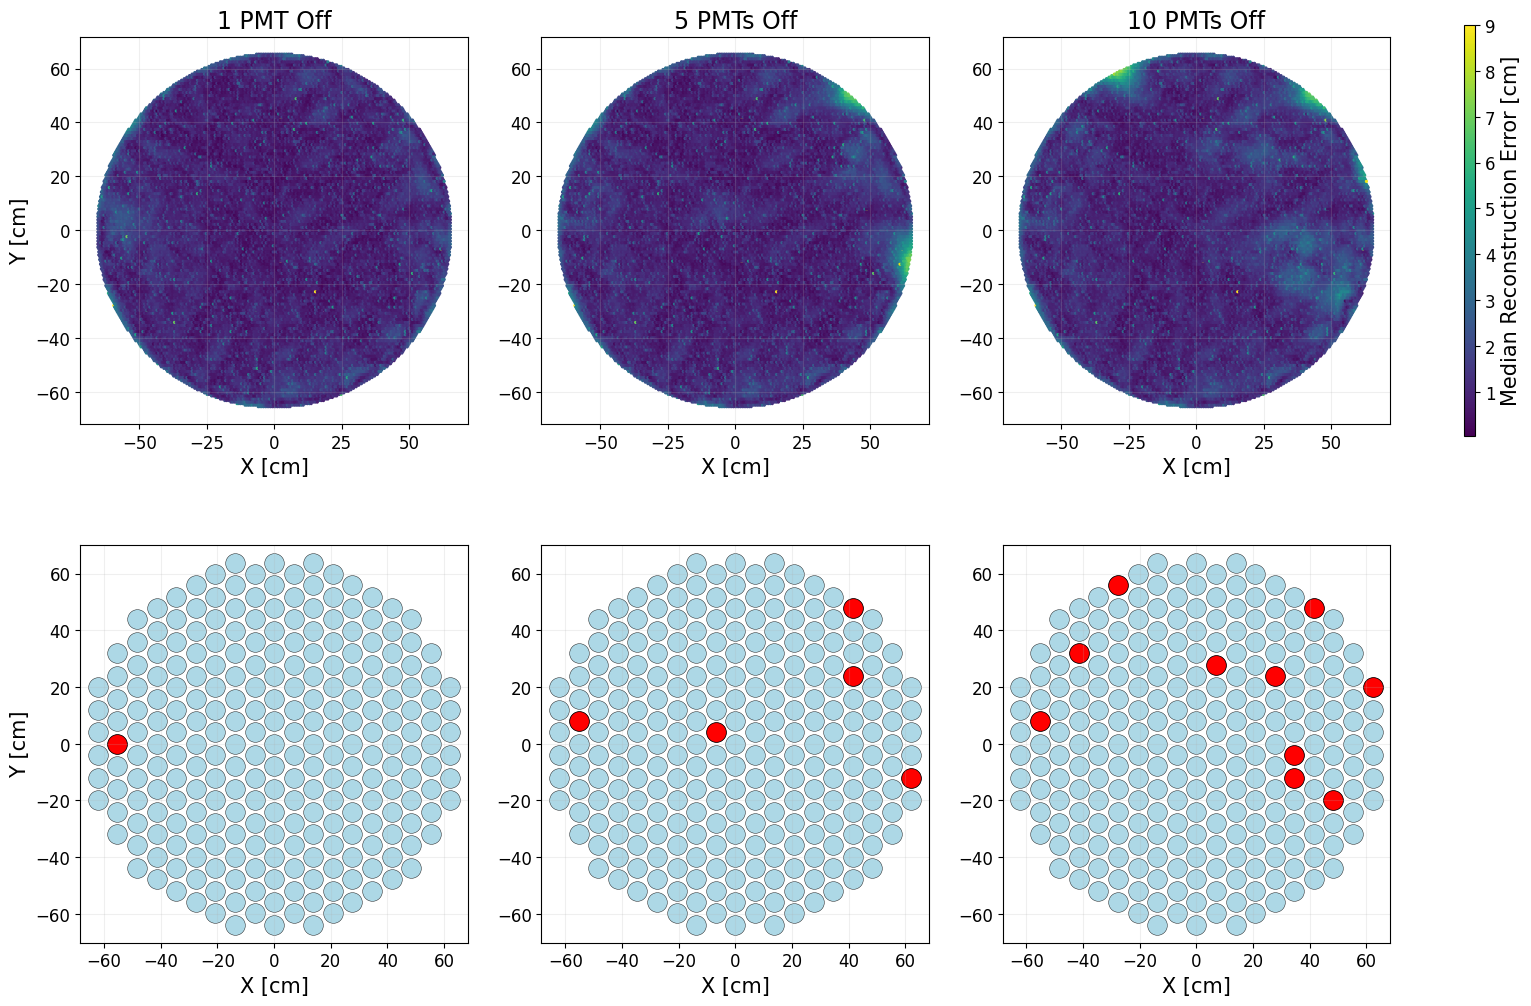

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

# --- Font size setup ---
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# --- Configuration ---
gridsize = 200
vmax = 9
area_key = "area_10_1e5"
mux_name = "adj_2"
variants = ["off_1", "off_5", "off_10"]
titles = ["1 PMT Off", "5 PMTs Off", "10 PMTs Off"]

# --- Load PMT positions ---
hex_data = np.load("hex_pattern_data.npz", allow_pickle=True)
pmt_xy_top = hex_data["pmt_xy_top"]
pmt_x_top = np.array(pmt_xy_top["x"])
pmt_y_top = np.array(pmt_xy_top["y"])

# --- Load variant results ---
analysis_file = f"saved_data_{mux_name}_analysis.npz"
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
analysis_path = os.path.join(data_dir, analysis_file)

all_results = {}
missing_pmt_sets = {}
with np.load(analysis_path, allow_pickle=True) as data:
    area_test = data["area_test"]
    pos_test = data["pos_test"]
    
    for variant in variants:
        key = f"pos_pred_{variant}"
        if key in data:
            pos_pred = data[key]
            mask = (area_test >= 10) & (area_test <= 1e5)
            abs_errors = np.linalg.norm(pos_pred - pos_test, axis=1)[mask]
            all_results[f"{variant}_{area_key}"] = {
                "pos_test": pos_test[mask],
                "abs_errors": abs_errors
            }
    
    for n_off in [1, 5, 10]:
        key = f"pmts_off_{n_off}"
        if key in data:
            missing_pmt_sets[n_off] = data[key]
        else:
            print(f"Key '{key}' not found in file.")

# --- Create figure and gridspec with space for colorbar on top row only ---
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.03], wspace=0.25, hspace=0.25)

# --- Axes for top and bottom rows ---
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]  # top row (hexbin)
axes += [fig.add_subplot(gs[1, i]) for i in range(3)]  # bottom row (PMT layout)
cax = fig.add_subplot(gs[0, 3])  # colorbar only on top row

# --- Top row: hexbin plots ---
for ax, variant, title in zip(axes[:3], variants, titles):
    key = f"{variant}_{area_key}"
    result = all_results[key]
    x = result["pos_test"][:, 0]
    y = result["pos_test"][:, 1]
    values = result["abs_errors"]

    hb = ax.hexbin(
        x, y,
        C=values,
        reduce_C_function=np.median,
        gridsize=gridsize,
        cmap='viridis',
        mincnt=1,
        vmax=vmax
    )

    ax.set_title(title)
    ax.set_xlabel("X [cm]")
    if ax is axes[0]:
        ax.set_ylabel("Y [cm]")
    ax.set_aspect("equal")
    ax.grid(alpha=0.2)

# --- Bottom row: PMT layouts ---
for ax, variant, title in zip(axes[3:], variants, titles):
    n_off = int(variant.split("_")[1])
    highlighted_pmts = missing_pmt_sets.get(n_off, [])

    ax.scatter(pmt_x_top, pmt_y_top, c='lightblue', marker='o', s=200, edgecolors='k', linewidth=0.3)
    ax.scatter(pmt_x_top[highlighted_pmts], pmt_y_top[highlighted_pmts], c='red', marker='o', s=200, edgecolors='k', linewidth=0.5)

    ax.set_xlabel("X [cm]")
    if ax is axes[3]:
        ax.set_ylabel("Y [cm]")
    ax.set_aspect("equal")
    ax.grid(alpha=0.2)

# --- Colorbar ---
cbar = fig.colorbar(hb, cax=cax)
cbar.set_label("Median Reconstruction Error [cm]")

# --- Show or save ---
# plt.savefig("adj2_pmts_off_2x3_combined.png", dpi=300)
plt.show()


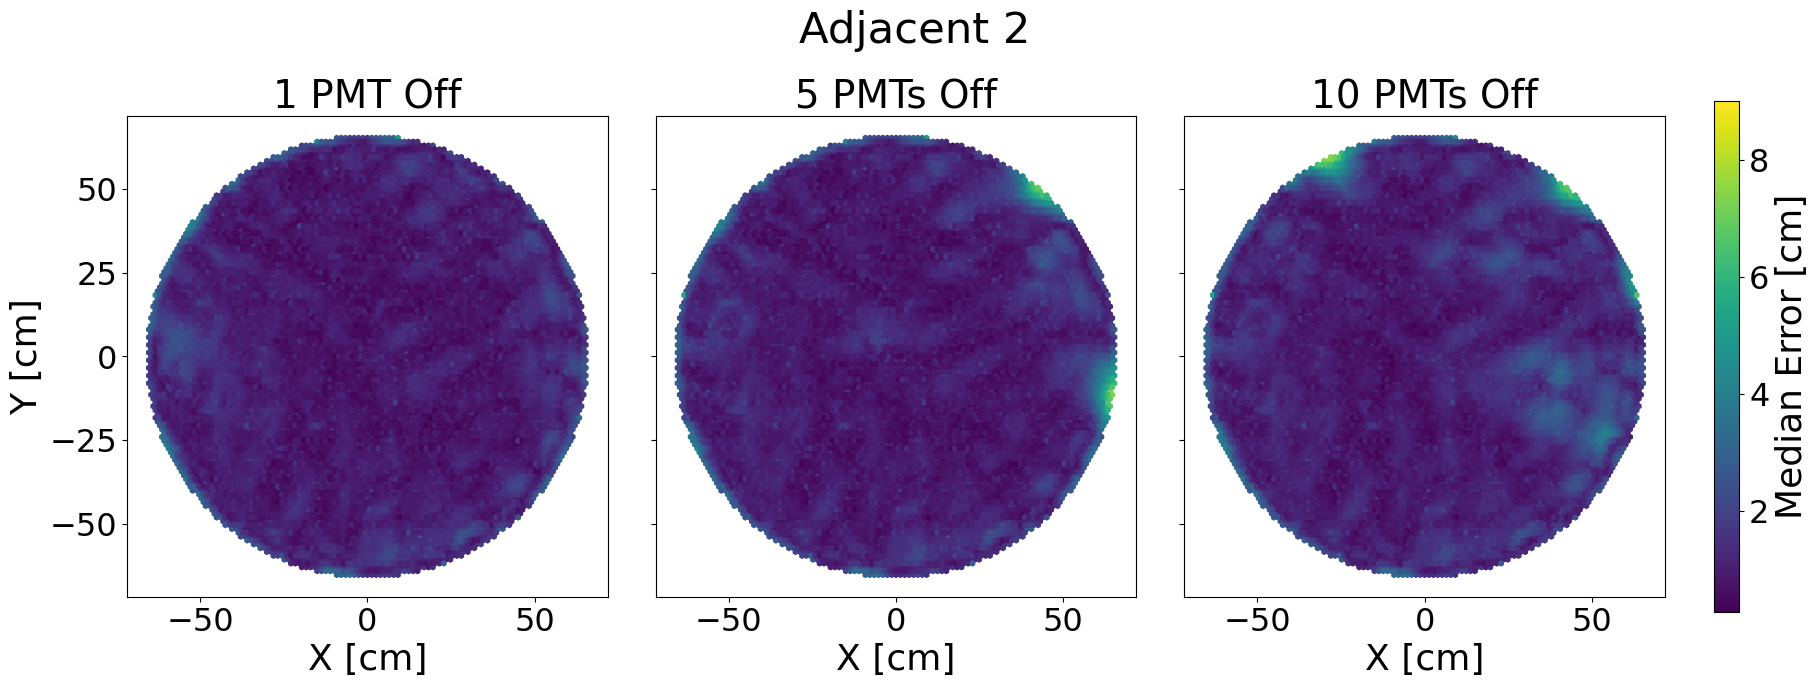

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Font size setup to match reference layout ---
plt.rcParams.update({
    "font.size": 26,
    "axes.labelsize": 26,
    "axes.titlesize": 28,
    "xtick.labelsize": 23,
    "ytick.labelsize": 23,
    "legend.fontsize": 26
})

# --- Configuration ---
gridsize = 100
vmax = 9
area_key = "area_10_1e5"
mux_name = "adj_2"
variants = ["off_1", "off_5", "off_10"]
titles = ["1 PMT Off", "5 PMTs Off", "10 PMTs Off"]

# --- Load data ---
data_dir = "/scratch/midway3/nkoebelin/mux_data_new/"
analysis_file = f"saved_data_{mux_name}_analysis.npz"
analysis_path = os.path.join(data_dir, analysis_file)

all_results = {}
with np.load(analysis_path, allow_pickle=True) as data:
    area_test = data["area_test"]
    pos_test = data["pos_test"]

    for variant in variants:
        pred_key = f"pos_pred_{variant}"
        if pred_key in data:
            pos_pred = data[pred_key]
            mask = (area_test >= 10) & (area_test <= 1e5)
            abs_errors = np.linalg.norm(pos_pred - pos_test, axis=1)[mask]
            all_results[f"{variant}_{area_key}"] = {
                "pos_test": pos_test[mask],
                "abs_errors": abs_errors
            }

# --- Create figure and axes ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, bottom=0.12, top=0.85)

# --- Loop through the variants ---
for ax, variant, title in zip(axes, variants, titles):
    key = f"{variant}_{area_key}"
    result = all_results[key]
    x = result["pos_test"][:, 0]
    y = result["pos_test"][:, 1]
    values = result["abs_errors"]

    hb = ax.hexbin(
        x, y,
        C=values,
        reduce_C_function=np.median,
        gridsize=gridsize,
        cmap='viridis',
        mincnt=1,
        vmax=vmax
    )

    ax.set_title(title)
    ax.set_xlabel("X [cm]")
    if ax is axes[0]:
        ax.set_ylabel("Y [cm]")

    ax.set_aspect("equal")
    #ax.grid(alpha=0.2)
    #ax.legend(title="Adjacent 2", loc="upper left")

# --- Main title ---
fig.suptitle("Adjacent 2")

# --- Shared colorbar ---
cbar = fig.colorbar(hb, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.025, pad=0.03)
cbar.set_label("Median Error [cm]")

# --- Show or save ---
#plt.savefig("adj2_pmt_off_hexbin.png", dpi=300)
plt.show()
